# Bellabeat Case Study

**About the Company:**
* [Bellabeat](https://bellabeat.com/) is a wellness technology company that manufactures health-focused products for women.
* Their goal is to become a larger player in the market by leveraging data-driven insights to improve their marketing strategy.

**Business Task:**
* Analyze trends on smart device usage data in order to provide insights to improve the company's marketing strategy.

## Imports

In [1]:
install.packages('skimr')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
install.packages('corrplot')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [3]:
install.packages("GGally")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘labelled’, ‘broom.helpers’, ‘patchwork’, ‘Rcpp’, ‘ggstats’, ‘plyr’




In [4]:
install.packages("ggrepel")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
install.packages("forcats")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [7]:
library(stringi)
library(data.table)
library(tidyr)
library(lubridate)
library(dplyr)
library(skimr)
library(ggplot2)
library(GGally)
library(corrplot)
library(ggrepel)
library(forcats)

## Loading Data

Link for download: https://www.kaggle.com/datasets/arashnic/fitbit

In [8]:
directory_path <- '/content/data'

file_list <- list.files(directory_path, full.names = TRUE, recursive = TRUE)

cat(file_list, sep = "\n")

/content/data/dailyActivity_merged.csv
/content/data/dailyCalories_merged.csv
/content/data/dailyIntensities_merged.csv
/content/data/dailySteps_merged.csv
/content/data/heartrate_seconds_merged.csv
/content/data/hourlyCalories_merged.csv
/content/data/hourlyIntensities_merged.csv
/content/data/hourlySteps_merged.csv
/content/data/minuteCaloriesNarrow_merged.csv
/content/data/minuteCaloriesWide_merged.csv
/content/data/minuteIntensitiesNarrow_merged.csv
/content/data/minuteIntensitiesWide_merged.csv
/content/data/minuteMETsNarrow_merged.csv
/content/data/minuteSleep_merged.csv
/content/data/minuteStepsNarrow_merged.csv
/content/data/minuteStepsWide_merged.csv
/content/data/sleepDay_merged.csv
/content/data/weightLogInfo_merged.csv


In [64]:
directory_path <- '/content/data'

database <- list()

file_list <- list.files(directory_path, pattern = "\\.csv$", full.names = TRUE, recursive = TRUE)

for (file_path in file_list) {
  name <- strsplit(basename(file_path), "_")[[1]][1]
  cat(name, "\n")

  df <- fread(file_path, verbose=FALSE)

  database[[name]] <- df
}

dailyActivity 
dailyCalories 
dailyIntensities 
dailySteps 
heartrate 
hourlyCalories 
hourlyIntensities 
hourlySteps 
minuteCaloriesNarrow 
minuteCaloriesWide 
minuteIntensitiesNarrow 
minuteIntensitiesWide 
minuteMETsNarrow 
minuteSleep 
minuteStepsNarrow 
minuteStepsWide 
sleepDay 
weightLogInfo 


## Preprocessing Data

First, we are going to set up a function to run basic checks on the data. This includes:
* Checking for missing values
* Checking for duplicate rows

In [21]:
run_check <- function(df) {

    # Find missing values
    rows_with_na <- sum(apply(df, 1, function(row) any(is.na(row))))
    cat("Number of rows with missing values: ", rows_with_na, "\n")

    # Find duplicate rows
    duplicate_rows <- nrow(df[duplicated(df), ])
    cat("Number of duplicate rows: ", duplicate_rows, "\n")
}

In [ ]:
for (name in names(database)) {
  cat("Processing dataframe:", name, "\n")

  df <- database[[name]]

  run_check(df)

  print("---------------------------------------------------------------------------------------")
}

Processing dataframe: dailyActivity 
Number of rows with missing values:  0 
Number of duplicate rows:  0 
[1] "---------------------------------------------------------------------------------------"
Processing dataframe: dailyCalories 
Number of rows with missing values:  0 
Number of duplicate rows:  0 
[1] "---------------------------------------------------------------------------------------"
Processing dataframe: dailyIntensities 
Number of rows with missing values:  0 
Number of duplicate rows:  0 
[1] "---------------------------------------------------------------------------------------"
Processing dataframe: dailySteps 
Number of rows with missing values:  0 
Number of duplicate rows:  0 
[1] "---------------------------------------------------------------------------------------"
Processing dataframe: heartrate 
Number of rows with missing values:  0 
Number of duplicate rows:  0 
[1] "---------------------------------------------------------------------------------------"

From the output, we've identified 543 duplicate rows in the minuteSleep dataset, 3 duplicate rows in the sleepDay dataset, and 65 rows with missing values in the weightLogInfo dataset. Moving forward, we will investigate these issues and address them appropriately.

## Cleaning Data

### Minute Sleep Dataset

In [11]:
# Load the minuteSleep dataset
df_min_sleep <- database[['minuteSleep']]
head(df_min_sleep)

Id,date,value,logId
<int64>,<chr>,<int>,<int64>
1503960366,4/12/2016 2:47:30 AM,3,11380564589
1503960366,4/12/2016 2:48:30 AM,2,11380564589
1503960366,4/12/2016 2:49:30 AM,1,11380564589
1503960366,4/12/2016 2:50:30 AM,1,11380564589
1503960366,4/12/2016 2:51:30 AM,1,11380564589
1503960366,4/12/2016 2:52:30 AM,1,11380564589


In [12]:
# Visualize duplicate rows
duplicates <- df_min_sleep[duplicated(df_min_sleep) | duplicated(df_min_sleep, fromLast = TRUE), ]
head(duplicates[with(duplicates, order(Id, date, value, logId)),])

Id,date,value,logId
<int64>,<chr>,<int>,<int64>
4702921684,5/6/2016 10:00:00 PM,1,11573168523
4702921684,5/6/2016 10:00:00 PM,1,11573168523
4702921684,5/6/2016 10:01:00 PM,1,11573168523
4702921684,5/6/2016 10:01:00 PM,1,11573168523
4702921684,5/6/2016 10:02:00 PM,1,11573168523
4702921684,5/6/2016 10:02:00 PM,1,11573168523


In [13]:
dim(duplicates)

[1] 1086    4

Clearly, there are 543 duplicate rows in the dataset. Since these rows contain identical data, we can proceed to remove them:

In [14]:
dim(df_min_sleep)

[1] 188521      4

In [15]:
# Remove duplicates
df_min_sleep <- unique(df_min_sleep)

In [ ]:
run_check(df_min_sleep)

Number of rows with missing values:  0 
Number of duplicate rows:  0 


Now, the duplicate rows have been removed.

### Sleep Day Dataset

In [16]:
# Load the sleepDay dataset
df_sleep_day <- database[['sleepDay']]
head(df_sleep_day)

Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
<int64>,<chr>,<int>,<int>,<int>
1503960366,4/12/2016 12:00:00 AM,1,327,346
1503960366,4/13/2016 12:00:00 AM,2,384,407
1503960366,4/15/2016 12:00:00 AM,1,412,442
1503960366,4/16/2016 12:00:00 AM,2,340,367
1503960366,4/17/2016 12:00:00 AM,1,700,712
1503960366,4/19/2016 12:00:00 AM,1,304,320


In [17]:
# Visualize duplicate rows
duplicates <- df_sleep_day[duplicated(df_sleep_day) | duplicated(df_sleep_day, fromLast = TRUE), ]
duplicates

Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
<int64>,<chr>,<int>,<int>,<int>
4388161847,5/5/2016 12:00:00 AM,1,471,495
4388161847,5/5/2016 12:00:00 AM,1,471,495
4702921684,5/7/2016 12:00:00 AM,1,520,543
4702921684,5/7/2016 12:00:00 AM,1,520,543
8378563200,4/25/2016 12:00:00 AM,1,388,402
8378563200,4/25/2016 12:00:00 AM,1,388,402


There are 6 duplicate rows in this dataset. Similar to the previous case, they can be removed using the 'unique' function:

In [18]:
df_sleep_day <- unique(df_sleep_day)

In [22]:
run_check(df_sleep_day)

Number of rows with missing values:  0 
Number of duplicate rows:  0 


Now, the dataset contains only unique values.

### Weight Log Info Dataset

In [23]:
df_weight <- database[['weightLogInfo']]
head(df_weight)

Id,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
<int64>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<lgl>,<int64>
1503960366,5/2/2016 11:59:59 PM,52.6,115.9631,22,22.65,TRUE,1462233599000
1503960366,5/3/2016 11:59:59 PM,52.6,115.9631,NA,22.65,TRUE,1462319999000
1927972279,4/13/2016 1:08:52 AM,133.5,294.3171,NA,47.54,FALSE,1460509732000
2873212765,4/21/2016 11:59:59 PM,56.7,125.0021,NA,21.45,TRUE,1461283199000
2873212765,5/12/2016 11:59:59 PM,57.3,126.3249,NA,21.69,TRUE,1463097599000
4319703577,4/17/2016 11:59:59 PM,72.4,159.6147,25,27.45,TRUE,1460937599000


In [24]:
dim(df_weight)

[1] 67  8

In [25]:
# Visualizing rows with missing values
df_weight[!complete.cases(df_weight), ]

Id,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
<int64>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<lgl>,<int64>
1503960366,5/3/2016 11:59:59 PM,52.6,115.9631,NA,22.65,TRUE,1462319999000
1927972279,4/13/2016 1:08:52 AM,133.5,294.3171,NA,47.54,FALSE,1460509732000
2873212765,4/21/2016 11:59:59 PM,56.7,125.0021,NA,21.45,TRUE,1461283199000
2873212765,5/12/2016 11:59:59 PM,57.3,126.3249,NA,21.69,TRUE,1463097599000
4319703577,5/4/2016 11:59:59 PM,72.3,159.3942,NA,27.38,TRUE,1462406399000
4558609924,4/18/2016 11:59:59 PM,69.7,153.6622,NA,27.25,TRUE,1461023999000
4558609924,4/25/2016 11:59:59 PM,70.3,154.9850,NA,27.46,TRUE,1461628799000
4558609924,5/1/2016 11:59:59 PM,69.9,154.1031,NA,27.32,TRUE,1462147199000
4558609924,5/2/2016 11:59:59 PM,69.2,152.5599,NA,27.04,TRUE,1462233599000


Notice that the "Fat" column contains many missing values.

In [26]:
# Visualizing rows with all values
df_weight[complete.cases(df_weight), ]

Id,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
<int64>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<lgl>,<int64>
1503960366,5/2/2016 11:59:59 PM,52.6,115.9631,22,22.65,TRUE,1462233599000
4319703577,4/17/2016 11:59:59 PM,72.4,159.6147,25,27.45,TRUE,1460937599000


Let's check the proportion of missing values relative to the total:

In [27]:
round(nrow(df_weight[!complete.cases(df_weight), ]) / nrow(df_weight), 2)

[1] 0.97

As evident, 97% of the dataset contains rows with missing values. Given the limited amount of data, this column will not be considered for the analysis.

In [28]:
df_weight <- subset(df_weight, select = -Fat)
head(df_weight)

Id,Date,WeightKg,WeightPounds,BMI,IsManualReport,LogId
<int64>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<int64>
1503960366,5/2/2016 11:59:59 PM,52.6,115.9631,22.65,TRUE,1462233599000
1503960366,5/3/2016 11:59:59 PM,52.6,115.9631,22.65,TRUE,1462319999000
1927972279,4/13/2016 1:08:52 AM,133.5,294.3171,47.54,FALSE,1460509732000
2873212765,4/21/2016 11:59:59 PM,56.7,125.0021,21.45,TRUE,1461283199000
2873212765,5/12/2016 11:59:59 PM,57.3,126.3249,21.69,TRUE,1463097599000
4319703577,4/17/2016 11:59:59 PM,72.4,159.6147,27.45,TRUE,1460937599000


In [29]:
run_check(df_weight)

Number of rows with missing values:  0 
Number of duplicate rows:  0 


Now there are no more missing values.

## Checking for Data Integrity

In [ ]:
df_count <- data.frame(Dataset = character(), DistinctIds = integer(), stringsAsFactors = FALSE)


for (name in names(database)) {

  current_dataset <- database[[name]]


  distinct_ids_count <- length(unique(current_dataset$Id))


  df_count <- rbind(df_count, data.frame(Dataset = name, DistinctIds = distinct_ids_count))
}


df_count[order(-df_count$DistinctIds), ]

,Dataset,DistinctIds
,<chr>,<int>
1,dailyActivity,33
2,dailyCalories,33
3,dailyIntensities,33
4,dailySteps,33
6,hourlyCalories,33
7,hourlyIntensities,33
8,hourlySteps,33
9,minuteCaloriesNarrow,33
10,minuteCaloriesWide,33


As observed, not all datasets include information for all thirty-three users who consented to share their data for this analysis. The sleep-related datasets had slightly fewer records, while both heartrate and weightLogInfo datasets had an even smaller number of entries. It's important to consider these limitations as we move forward with the analysis.

## Analyzing Data

### Hourly Trends

Here are some useful functions for formatting the data:

In [30]:
format_hour_dataset <- function(df, hour_col) {
  df$ActivityHour <- mdy_hms(df[[hour_col]] )
  df <- df %>% mutate(
    Date = format(ActivityHour, "%m/%d/%Y"),
    Hour = hour(hms(format(ActivityHour, "%H:%M:%S"))),
    TimeOfDay = case_when(
      hour(ActivityHour) >= 5 & hour(ActivityHour) <= 11 ~ "Morning",
      hour(ActivityHour) >= 12 & hour(ActivityHour) <= 18 ~ "Afternoon",
      hour(ActivityHour) >= 19 & hour(ActivityHour) <= 23 ~ "Night",
      TRUE ~ "Dawn"
    )

  )
  return(df)
}

In [31]:
summarise_hour <- function(df, metric) {
  df_agg <- df %>%
    group_by(Hour) %>%
    summarise(HourAvg = mean({{metric}}),
              Sum = sum({{metric}}),
              Min = min({{metric}}),
              Max = max({{metric}}),
              Stdev = sd({{metric}}),
              Q25 = quantile({{metric}}, probs = 0.25, na.rm = TRUE),
              Median = median({{metric}}),
              Q75 = quantile({{metric}}, probs = 0.75, na.rm = TRUE),
              Range = max({{metric}}) - min({{metric}}),
              .groups = 'drop'
    )

    return(df_agg)
}

In [32]:
summarise_time_of_day <- function(df, metric) {
  df_agg <- df %>%
    group_by(Id, Date, TimeOfDay) %>%
    summarise(TimeSum = sum({{metric}}),
              .groups = 'drop'
    ) %>%
    group_by(Id, TimeOfDay) %>%
    summarise(TimeAvg = mean(TimeSum),
              .groups = 'drop'
    ) %>%
    group_by(TimeOfDay) %>%
    summarise(Avg = mean(TimeAvg),
              Sum = sum(TimeAvg),
              Min = min(TimeAvg),
              Max = max(TimeAvg),
              Stdev = sd(TimeAvg),
              Q25 = quantile(TimeAvg, probs = 0.25, na.rm = TRUE),
              Median = median(TimeAvg),
              Q75 = quantile(TimeAvg, probs = 0.75, na.rm = TRUE),
              Range = max(TimeAvg) - min(TimeAvg),
              .groups = 'drop'
    )

    return(df_agg)
}

#### Calories

In [33]:
df_hour_cal <- database[['hourlyCalories']]
head(df_hour_cal)

Id,ActivityHour,Calories
<int64>,<chr>,<int>
1503960366,4/12/2016 12:00:00 AM,81
1503960366,4/12/2016 1:00:00 AM,61
1503960366,4/12/2016 2:00:00 AM,59
1503960366,4/12/2016 3:00:00 AM,47
1503960366,4/12/2016 4:00:00 AM,48
1503960366,4/12/2016 5:00:00 AM,48


In [34]:
df_hour_cal <- format_hour_dataset(df_hour_cal, 'ActivityHour')
head(df_hour_cal)

Id,ActivityHour,Calories,Date,Hour,TimeOfDay
<int64>,<dttm>,<int>,<chr>,<dbl>,<chr>
1503960366,2016-04-12 00:00:00,81,04/12/2016,0,Dawn
1503960366,2016-04-12 01:00:00,61,04/12/2016,1,Dawn
1503960366,2016-04-12 02:00:00,59,04/12/2016,2,Dawn
1503960366,2016-04-12 03:00:00,47,04/12/2016,3,Dawn
1503960366,2016-04-12 04:00:00,48,04/12/2016,4,Dawn
1503960366,2016-04-12 05:00:00,48,04/12/2016,5,Morning


In [35]:
# Checking for integrity
df_hour_cal %>%
  group_by(Date) %>%
  summarise(Hours = n_distinct(Hour)) %>%
  arrange(Hours)

Date,Hours
<chr>,<int>
05/12/2016,16
04/12/2016,24
04/13/2016,24
04/14/2016,24
04/15/2016,24
04/16/2016,24
04/17/2016,24
04/18/2016,24
04/19/2016,24


As evident, there are incomplete records for the date 05/12/2016. Since this imbalance could potentially skew the results, this date will not be considered for the analysis.

In [36]:
df_hour_cal <- df_hour_cal %>%
  filter(!(Date %in% c('05/12/2016')))

In [37]:
df_agg_hour_cal <- summarise_hour(df_hour_cal, Calories)
df_agg_hour_cal

Hour,HourAvg,Sum,Min,Max,Stdev,Q25,Median,Q75,Range
<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,71.91148,65799,42,244,19.97728,56,70.0,84.00,202
1,70.22538,64186,42,412,21.57499,56,68.0,84.00,370
2,69.22429,63271,42,476,21.60988,56,68.0,83.00,434
3,67.56127,61751,42,155,14.49119,56,65.0,80.00,113
4,68.27790,62406,42,209,16.91307,56,65.0,79.75,167
5,81.98140,74931,42,669,82.98702,56,68.0,83.00,627
6,87.08981,79513,42,511,58.93109,59,73.0,86.00,469
7,94.41512,86201,42,464,46.55761,62,83.0,115.00,422
8,103.49617,94492,42,493,64.13964,68,84.0,118.00,451


In [38]:
df_agg_tod_cal <- summarise_time_of_day(df_hour_cal, Calories)
df_agg_tod_cal

TimeOfDay,Avg,Sum,Min,Max,Stdev,Q25,Median,Q75,Range
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afternoon,801.5803,26452.15,463.8333,1569.8000,244.75109,642.1667,705.2333,952.1000,1105.9667
Dawn,345.7908,11411.10,223.6897,482.2000,71.66782,285.3889,331.1786,403.6667,258.5103
Morning,691.6232,22823.57,372.6552,1346.9000,225.63810,544.2667,647.4000,721.8333,974.2448
Night,479.7946,15833.22,297.4000,906.8667,134.74037,396.3333,450.8889,524.2667,609.4667


In [39]:
# Average calories burned a day
sum(df_agg_tod_cal$Avg)

[1] 2318.789

In [40]:
options(repr.plot.width = 15, repr.plot.height = 10)

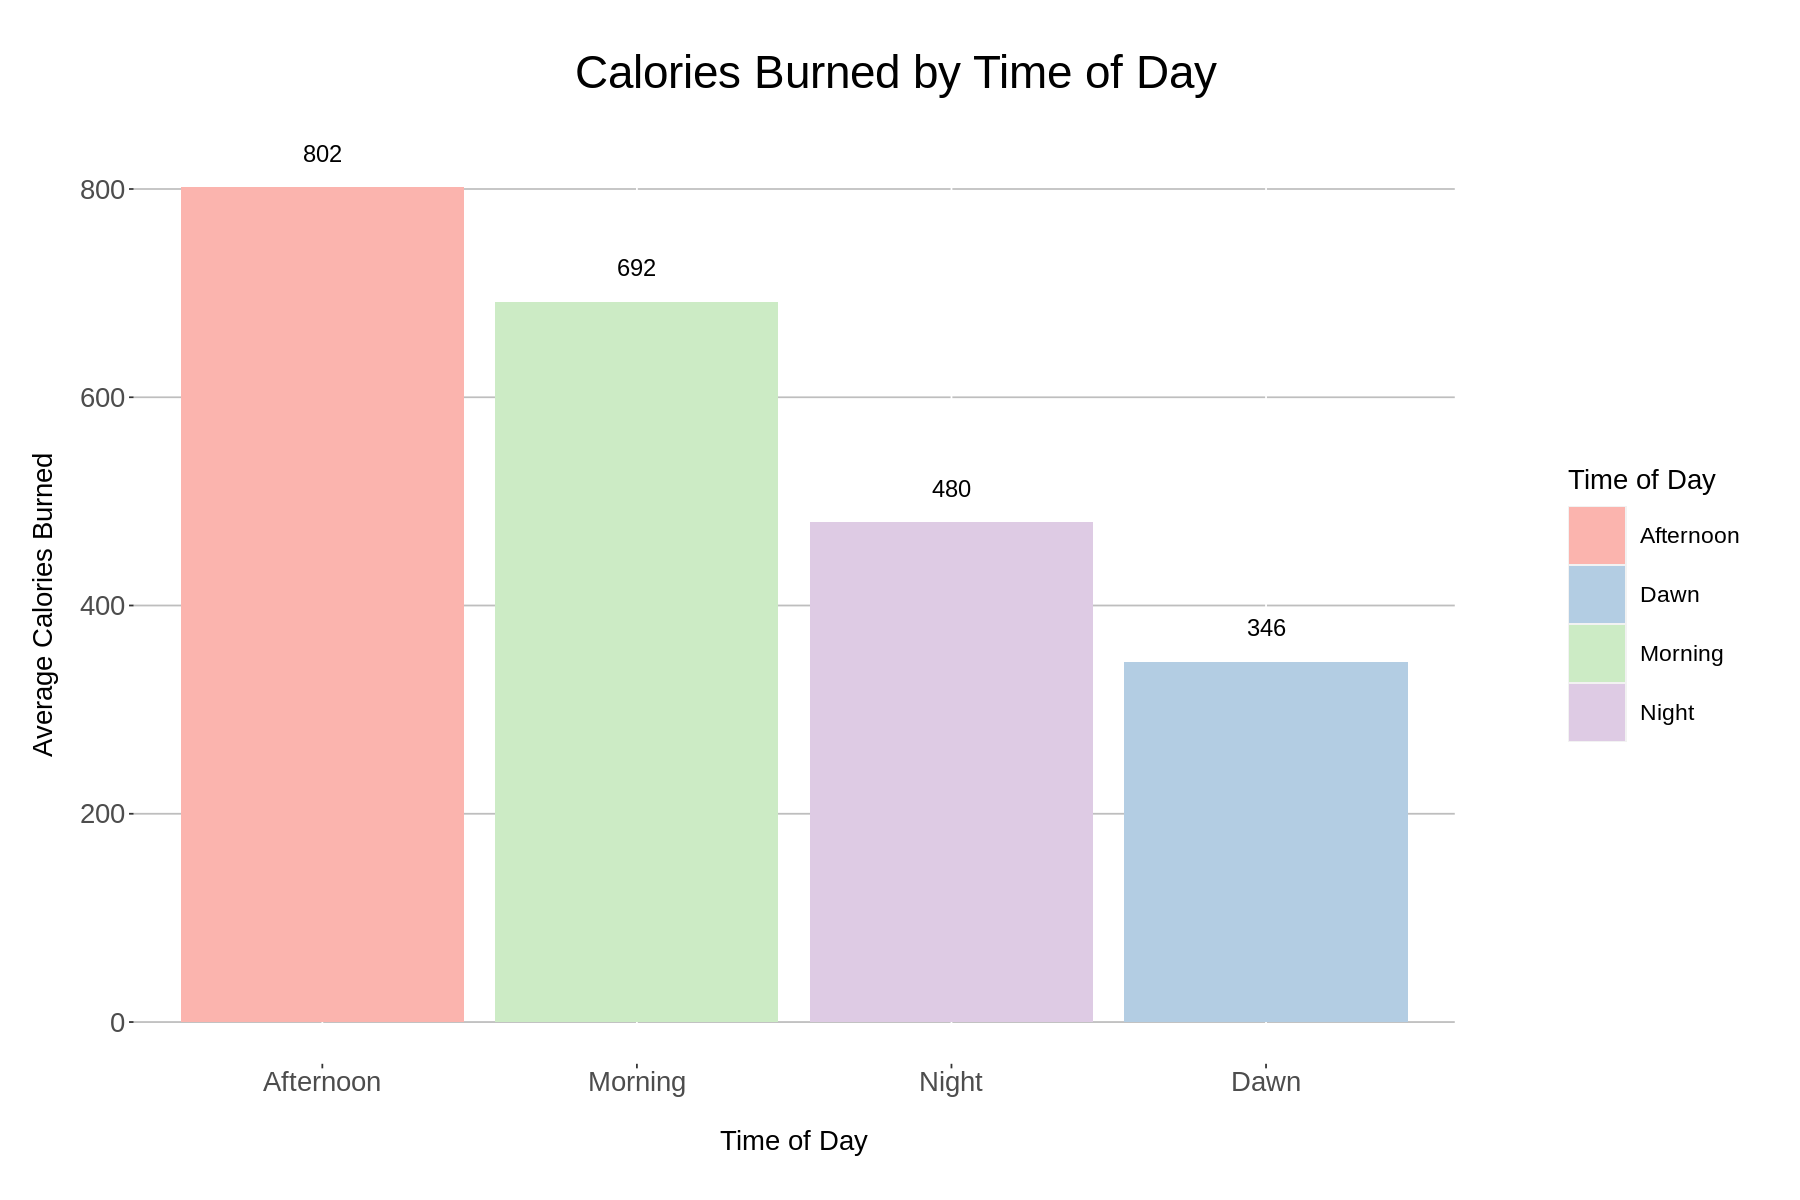

In [41]:
# Calories Burned By Time of Day
ggplot(df_agg_tod_cal, aes(x = reorder(TimeOfDay, -Avg), y = Avg, fill = TimeOfDay)) +
  scale_fill_brewer(palette = "Pastel1") +
  geom_bar(stat = "identity") +
  labs(title = "Calories Burned by Time of Day",
       x = "Time of Day",
       y = "Average Calories Burned") +
  geom_text(aes(label = round(Avg)), vjust = -1.5, size = 5) +
  guides(fill = guide_legend(title = "Time of Day")) +
  theme(legend.key.size = unit(1.25, 'cm'),
        legend.text = element_text(size = rel(1.25)),
        legend.title = element_text(size = rel(1.5)),
        legend.margin = margin(0, 1, 0, 2, 'cm'),
        plot.title = element_text(size = rel(2.5), hjust = 0.65, margin = margin(1, 0, 1, 0, 'cm')),
        axis.text = element_text(size = rel(1.5)),
        axis.title.x = element_text(size = rel(1.5), margin = margin(0.75, 0, 0.75, 0, 'cm')),
        axis.title.y = element_text(size = rel(1.5), margin = margin(0, 0.5, 0, 0.5, 'cm')),
        panel.grid.major.y = element_line(colour='grey'),
        panel.background  = element_blank())

The chart above shows that people tend to burn more calories in the afternoon, followed by morning, night, and dawn.

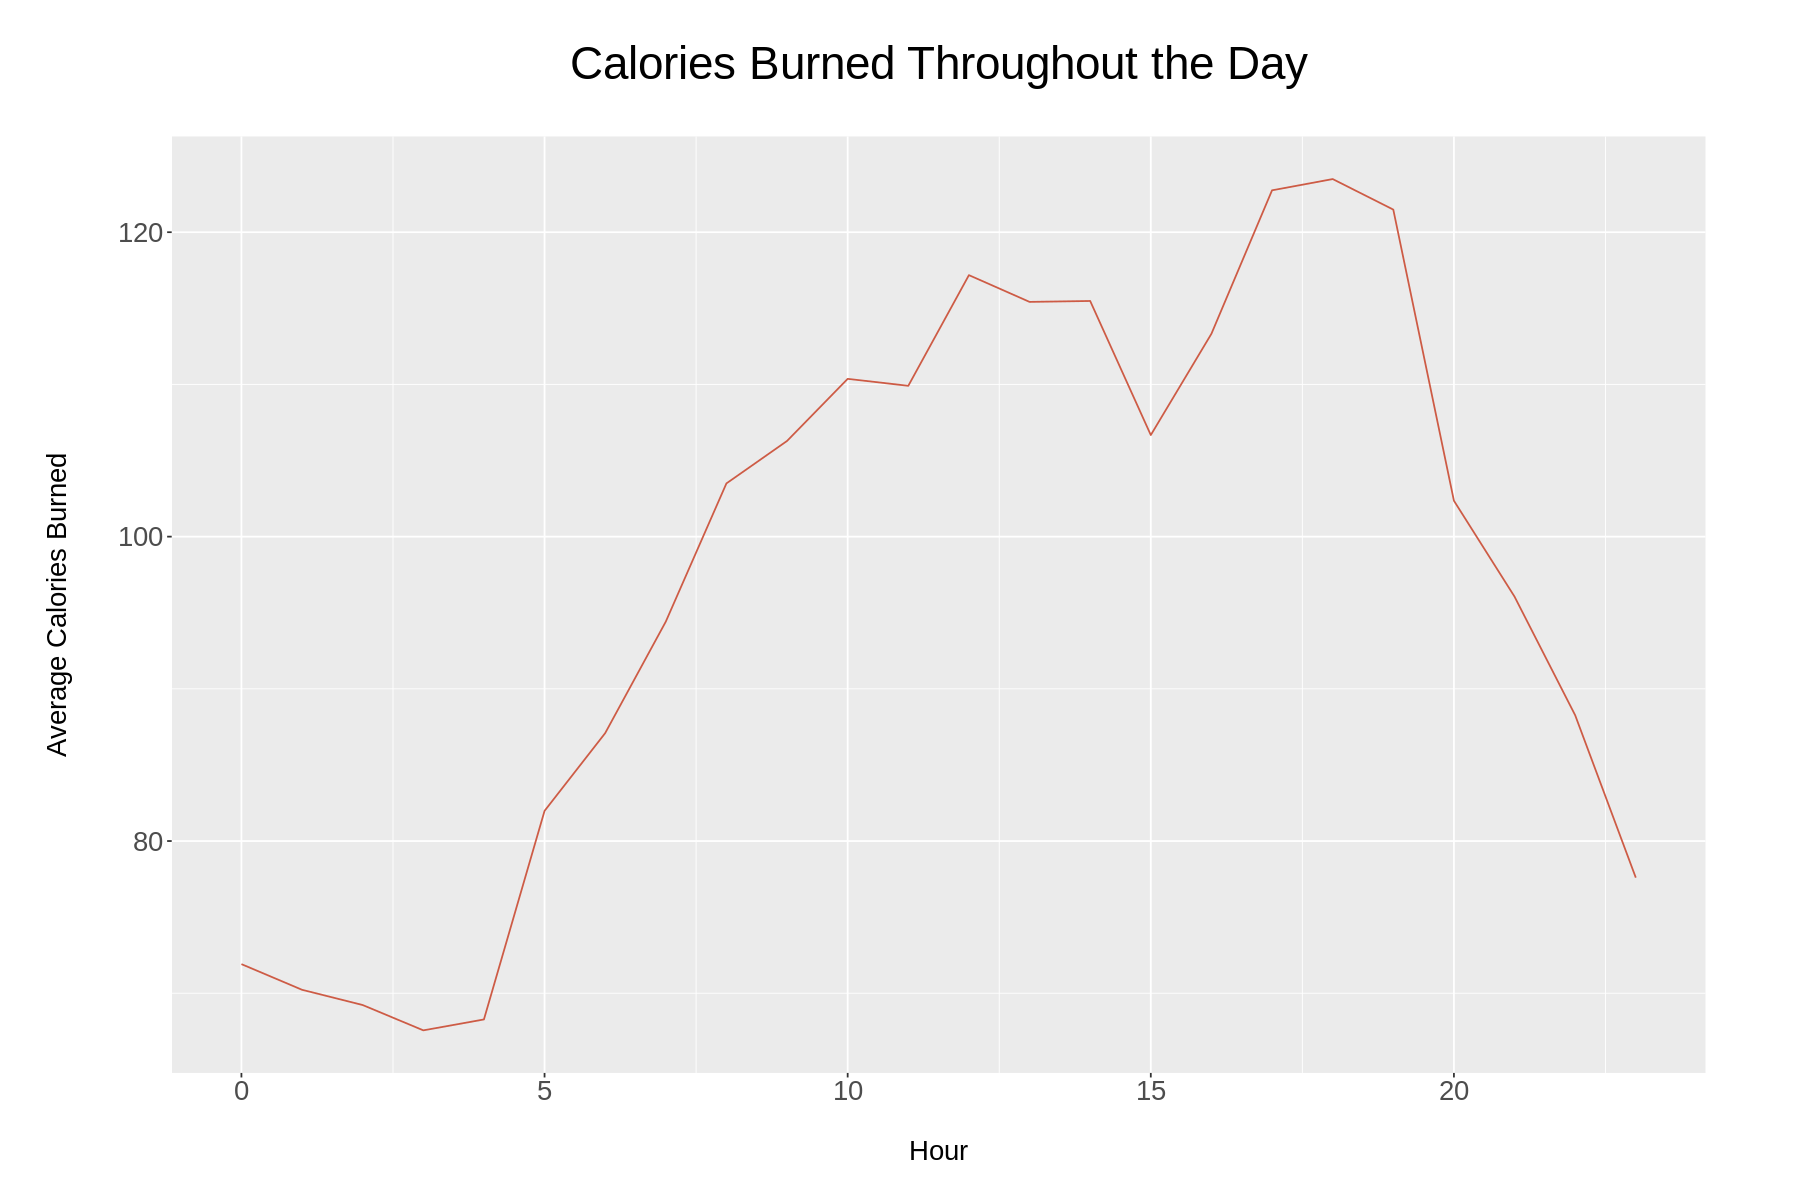

In [42]:
# Calories Burned Throughout the Day
ggplot(df_agg_hour_cal, aes(x = Hour, y = HourAvg)) +
  geom_line(col='coral3') +
  labs(title = "Calories Burned Throughout the Day",
       x = "Hour",
       y = "Average Calories Burned") +
  theme(legend.key.size = unit(1.25, 'cm'),
        legend.text = element_text(size = rel(1.25)),
        legend.title = element_text(size = rel(1.5)),
        plot.title = element_text(size = rel(2.5), hjust = 0.5, margin = margin(1, 0, 1, 0, 'cm')),
        axis.text = element_text(size = rel(1.5)),
        axis.title.x = element_text(size = rel(1.5), margin = margin(0.75, 0, 0.75, 0, 'cm')),
        axis.title.y = element_text(size = rel(1.5), margin = margin(0, 1, 0, 1, 'cm')),
        plot.margin = margin(0, 2, 0, 0, 'cm'))

In [43]:
head(df_agg_hour_cal[order(-df_agg_hour_cal$HourAvg), ], n=10)

Hour,HourAvg,Sum,Min,Max,Stdev,Q25,Median,Q75,Range
<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
18,123.4923,111884,44,834,79.84264,79,103.0,142,790
17,122.7528,111214,43,835,82.97377,78,100.0,139,792
19,121.4845,110065,44,651,78.67547,77,96.0,135,607
12,117.1793,106516,42,730,72.74382,77,96.0,133,688
14,115.4818,104973,42,948,77.81031,74,93.0,129,906
13,115.4213,104918,42,705,69.59149,76,97.0,129,663
16,113.3275,102788,44,886,66.96322,77,98.0,130,842
10,110.3651,100653,42,544,61.47718,73,90.5,126,502
11,109.9079,100236,42,519,58.92066,73,93.0,128,477


These results suggest that there is a peak in calories burned at 5-7PM. We will proceed to explore other variables and try to identify patterns that might correlate to this behavior.

#### Intensities

In [44]:
df_hour_int <- database[['hourlyIntensities']]
head(df_hour_int)

Id,ActivityHour,TotalIntensity,AverageIntensity
<int64>,<chr>,<int>,<dbl>
1503960366,4/12/2016 12:00:00 AM,20,0.333333
1503960366,4/12/2016 1:00:00 AM,8,0.133333
1503960366,4/12/2016 2:00:00 AM,7,0.116667
1503960366,4/12/2016 3:00:00 AM,0,0.000000
1503960366,4/12/2016 4:00:00 AM,0,0.000000
1503960366,4/12/2016 5:00:00 AM,0,0.000000


In [45]:
df_hour_int <- format_hour_dataset(df_hour_int, 'ActivityHour')
head(df_hour_int)

Id,ActivityHour,TotalIntensity,AverageIntensity,Date,Hour,TimeOfDay
<int64>,<dttm>,<int>,<dbl>,<chr>,<dbl>,<chr>
1503960366,2016-04-12 00:00:00,20,0.333333,04/12/2016,0,Dawn
1503960366,2016-04-12 01:00:00,8,0.133333,04/12/2016,1,Dawn
1503960366,2016-04-12 02:00:00,7,0.116667,04/12/2016,2,Dawn
1503960366,2016-04-12 03:00:00,0,0.000000,04/12/2016,3,Dawn
1503960366,2016-04-12 04:00:00,0,0.000000,04/12/2016,4,Dawn
1503960366,2016-04-12 05:00:00,0,0.000000,04/12/2016,5,Morning


In [46]:
# Checking for integrity
df_hour_int %>%
  group_by(Date) %>%
  summarise(Hours = n_distinct(Hour)) %>%
  arrange(Hours)

Date,Hours
<chr>,<int>
05/12/2016,16
04/12/2016,24
04/13/2016,24
04/14/2016,24
04/15/2016,24
04/16/2016,24
04/17/2016,24
04/18/2016,24
04/19/2016,24


In [47]:
# Removing incomplete records
df_hour_int <- df_hour_int %>%
  filter(!(Date %in% c('05/12/2016')))

In [48]:
df_agg_hour_int <- summarise_hour(df_hour_int, TotalIntensity)
df_agg_hour_int

Hour,HourAvg,Sum,Min,Max,Stdev,Q25,Median,Q75,Range
<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,2.1661202,1982,0,55,5.251315,0,0,1,55
1,1.4354486,1312,0,97,5.352696,0,0,0,97
2,1.0503282,960,0,118,5.118282,0,0,0,118
3,0.4485777,410,0,35,2.066815,0,0,0,35
4,0.6356674,581,0,32,2.609209,0,0,0,32
5,5.0317287,4599,0,165,22.896694,0,0,0,165
6,7.7973713,7119,0,160,19.613914,0,0,6,160
7,10.7250821,9792,0,147,17.526859,0,2,16,147
8,14.7119387,13432,0,174,25.327964,0,6,19,174


In [49]:
df_agg_tod_int <- summarise_time_of_day(df_hour_int, TotalIntensity)
df_agg_tod_int

TimeOfDay,Avg,Sum,Min,Max,Stdev,Q25,Median,Q75,Range
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afternoon,131.029547,4323.975,21.16667,282.33333,59.981797,102.27586,137.94118,153.550000,261.16667
Dawn,5.459273,180.156,0.00000,18.23333,4.772489,1.20000,3.80000,9.333333,18.23333
Morning,88.591046,2923.505,10.90000,256.24000,64.626696,37.56667,74.05556,116.500000,245.34000
Night,60.108365,1983.576,8.70000,191.50000,41.448754,32.53333,50.53333,75.833333,182.80000


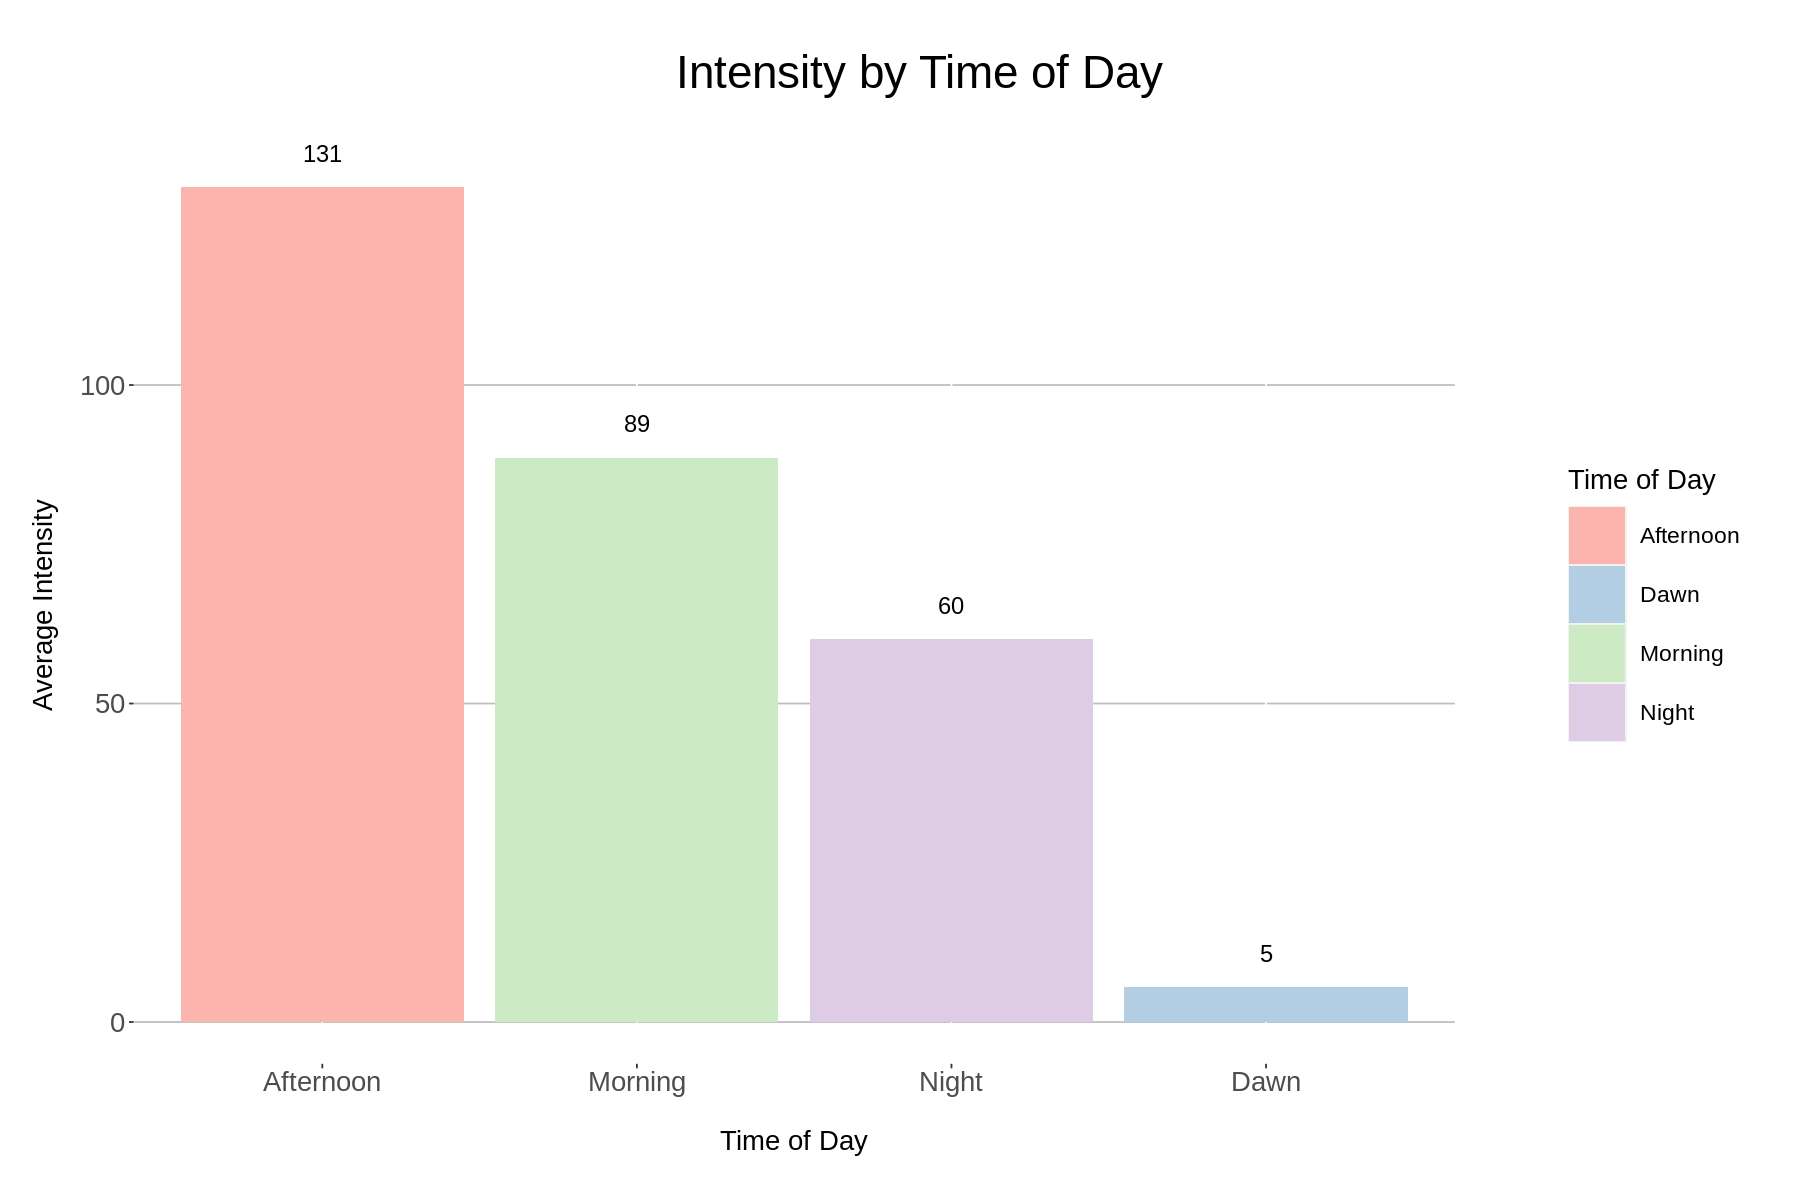

In [50]:
# Intensity By Time of Day
ggplot(df_agg_tod_int, aes(x = reorder(TimeOfDay, -Avg), y = Avg, fill = TimeOfDay)) +
  scale_fill_brewer(palette = "Pastel1") +
  geom_bar(stat = "identity") +
  labs(title = "Intensity by Time of Day",
       x = "Time of Day",
       y = "Average Intensity") +
  geom_text(aes(label = round(Avg)), vjust = -1.5, size = 5) +
  guides(fill = guide_legend(title = "Time of Day")) +
  theme(legend.key.size = unit(1.25, 'cm'),
        legend.text = element_text(size = rel(1.25)),
        legend.title = element_text(size = rel(1.5)),
        legend.margin = margin(0, 1, 0, 2, 'cm'),
        plot.title = element_text(size = rel(2.5), hjust = 0.65, margin = margin(1, 0, 1, 0, 'cm')),
        axis.text = element_text(size = rel(1.5)),
        axis.title.x = element_text(size = rel(1.5), margin = margin(0.75, 0, 0.75, 0, 'cm')),
        axis.title.y = element_text(size = rel(1.5), margin = margin(0, 0.5, 0, 0.5, 'cm')),
        panel.grid.major.y = element_line(colour='grey'),
        panel.background  = element_blank())

When considering the time of day, the trend for average intensity aligns with that of average calories burned. This correlation is accurate, as more intense activities result in higher energy expenditure.

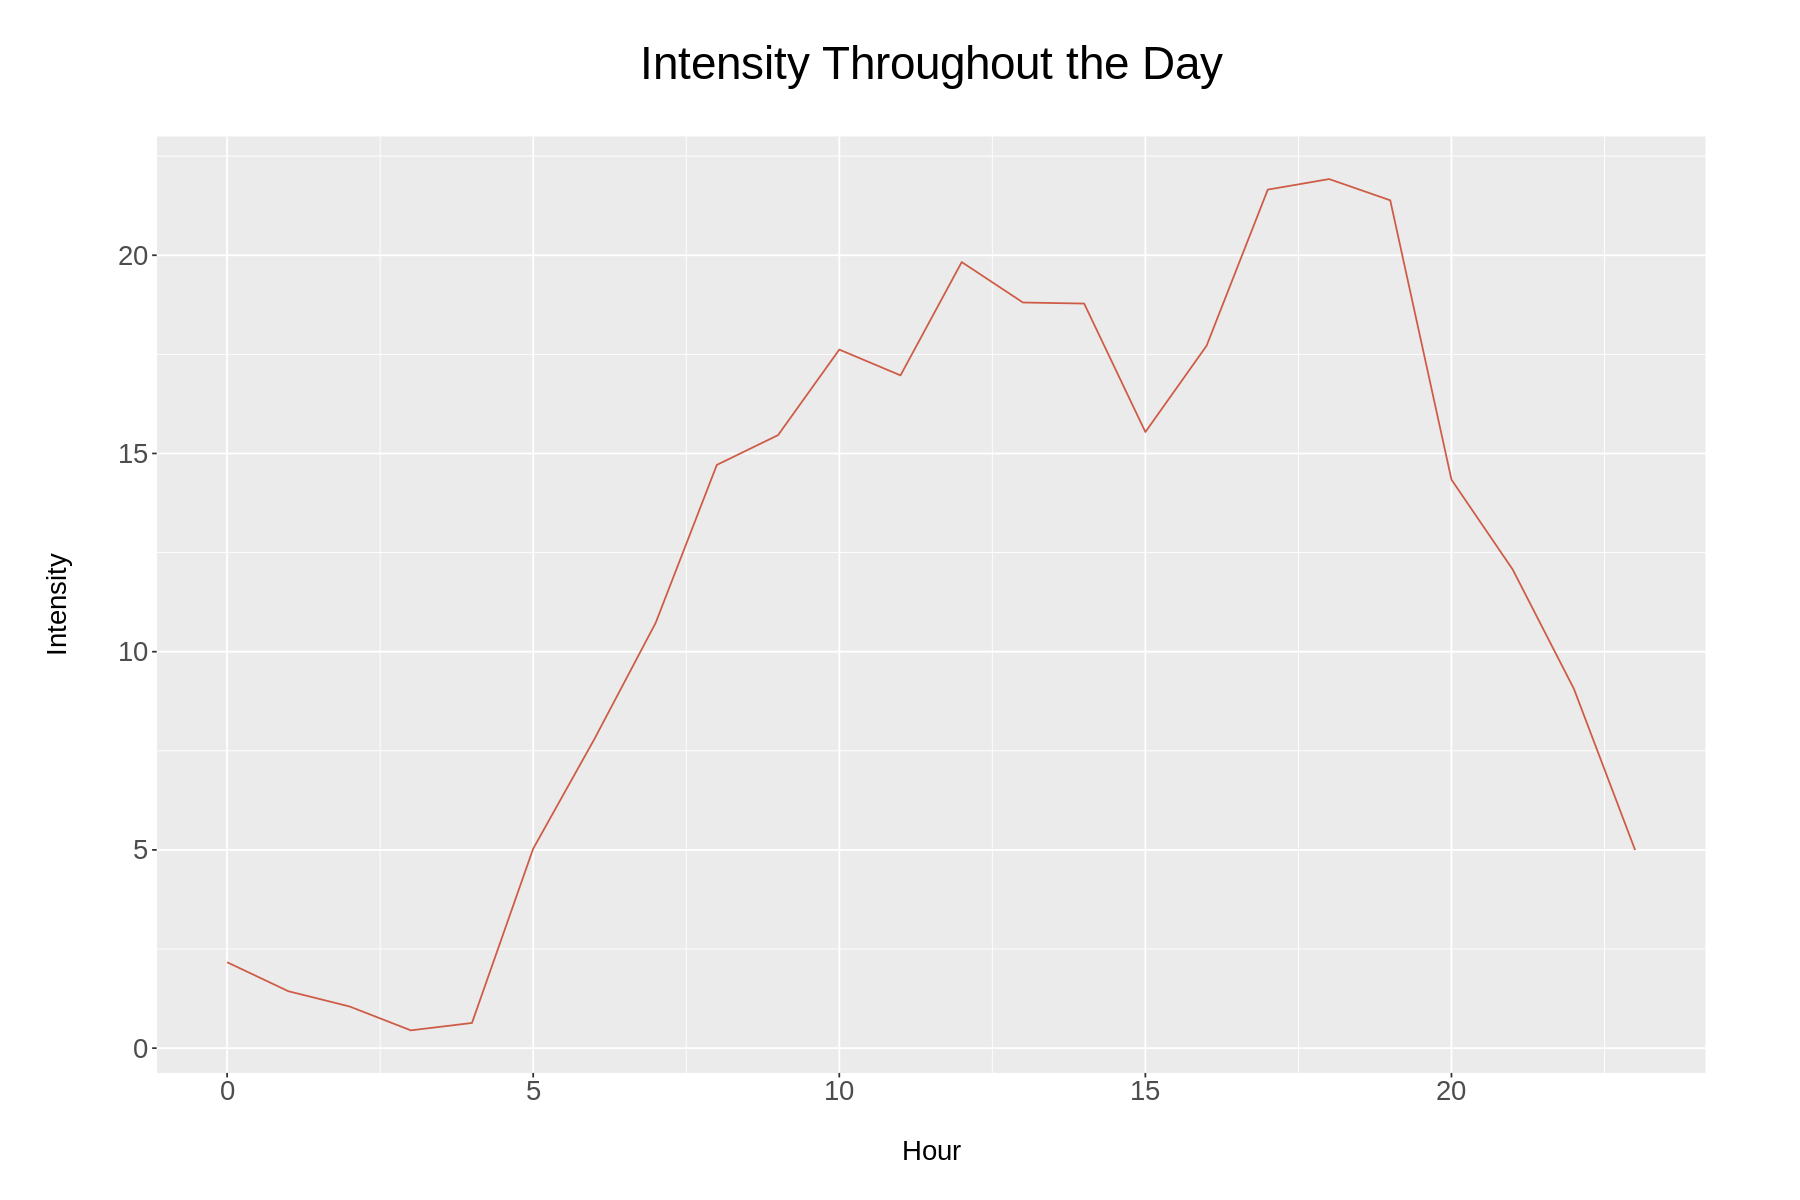

In [51]:
# Intensity Throughout the Day
ggplot(df_agg_hour_int, aes(x = Hour, y = HourAvg)) +
  geom_line(col='coral3') +
  labs(title = "Intensity Throughout the Day",
       x = "Hour",
       y = "Intensity") +
  theme(legend.key.size = unit(1.25, 'cm'),
        legend.text = element_text(size = rel(1.25)),
        legend.title = element_text(size = rel(1.5)),
        plot.title = element_text(size = rel(2.5), hjust = 0.5, margin = margin(1, 0, 1, 0, 'cm')),
        axis.text = element_text(size = rel(1.5)),
        axis.title.x = element_text(size = rel(1.5), margin = margin(0.75, 0, 0.75, 0, 'cm')),
        axis.title.y = element_text(size = rel(1.5), margin = margin(0, 1, 0, 1, 'cm')),
        plot.margin = margin(0, 2, 0, 0, 'cm'))

In [52]:
head(df_agg_hour_int[order(-df_agg_hour_int$HourAvg), ], n=10)

Hour,HourAvg,Sum,Min,Max,Stdev,Q25,Median,Q75,Range
<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
18,21.92163,19861,0,180,25.89604,4,16,29,180
17,21.65563,19620,0,168,27.38763,4,16,27,168
19,21.38521,19375,0,179,27.56474,3,13,26,179
12,19.82728,18023,0,158,24.64161,4,13,25,158
13,18.80748,17096,0,180,24.33303,2,12,25,180
14,18.78108,17072,0,180,25.42735,2,11,25,180
16,17.71665,16069,0,173,20.97544,3,12,24,173
10,17.61952,16069,0,173,24.29482,0,10,23,173
11,16.96930,15476,0,170,21.64926,2,11,24,170


Note that it is incredibly similar to the calories burned throughout the day plot. We will explore this correlation further down the analysis.

#### Steps

In [53]:
df_hour_steps <- database[['hourlySteps']]
head(df_hour_steps)

Id,ActivityHour,StepTotal
<int64>,<chr>,<int>
1503960366,4/12/2016 12:00:00 AM,373
1503960366,4/12/2016 1:00:00 AM,160
1503960366,4/12/2016 2:00:00 AM,151
1503960366,4/12/2016 3:00:00 AM,0
1503960366,4/12/2016 4:00:00 AM,0
1503960366,4/12/2016 5:00:00 AM,0


In [54]:
df_hour_steps <- format_hour_dataset(df_hour_steps, 'ActivityHour')
head(df_hour_steps)

Id,ActivityHour,StepTotal,Date,Hour,TimeOfDay
<int64>,<dttm>,<int>,<chr>,<dbl>,<chr>
1503960366,2016-04-12 00:00:00,373,04/12/2016,0,Dawn
1503960366,2016-04-12 01:00:00,160,04/12/2016,1,Dawn
1503960366,2016-04-12 02:00:00,151,04/12/2016,2,Dawn
1503960366,2016-04-12 03:00:00,0,04/12/2016,3,Dawn
1503960366,2016-04-12 04:00:00,0,04/12/2016,4,Dawn
1503960366,2016-04-12 05:00:00,0,04/12/2016,5,Morning


In [55]:
# Checking for integrity
df_hour_steps %>%
  group_by(Date) %>%
  summarise(Hours = n_distinct(Hour)) %>%
  arrange(Hours)

Date,Hours
<chr>,<int>
05/12/2016,16
04/12/2016,24
04/13/2016,24
04/14/2016,24
04/15/2016,24
04/16/2016,24
04/17/2016,24
04/18/2016,24
04/19/2016,24


In [56]:
# Removing incomplete records
df_hour_steps <- df_hour_steps %>%
  filter(!(Date %in% c('05/12/2016')))

In [57]:
df_agg_hour_steps <- summarise_hour(df_hour_steps, StepTotal)
df_agg_hour_steps

Hour,HourAvg,Sum,Min,Max,Stdev,Q25,Median,Q75,Range
<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,42.990164,39336,0,2128,137.19263,0.00,0.0,14.00,2128
1,23.422319,21408,0,1887,105.37364,0.00,0.0,0.00,1887
2,17.159737,15684,0,1983,88.58604,0.00,0.0,0.00,1983
3,6.543764,5981,0,564,36.43219,0.00,0.0,0.00,564
4,12.853392,11748,0,1036,65.50758,0.00,0.0,0.00,1036
5,44.268053,40461,0,2844,214.75913,0.00,0.0,0.00,2844
6,179.064622,163486,0,5742,478.93215,0.00,0.0,107.00,5742
7,304.450164,277963,0,7609,596.45397,0.00,15.0,432.00,7609
8,430.084337,392667,0,8520,882.80862,0.00,115.0,473.00,8520


In [58]:
df_agg_tod_steps <- summarise_time_of_day(df_hour_steps, StepTotal)
df_agg_tod_steps

TimeOfDay,Avg,Sum,Min,Max,Stdev,Q25,Median,Q75,Range
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afternoon,3575.52729,117992.401,419.8333,10108.67,2072.30631,2742.53333,3267.60000,4518.1000,9688.833
Dawn,97.45792,3216.111,0.0000,371.50,95.62328,11.33333,51.83333,170.5333,371.500
Morning,2363.65613,78000.652,268.7667,7715.00,1671.48270,1044.30000,2256.33333,3600.6111,7446.233
Night,1553.44460,51263.672,138.4667,6825.20,1498.45572,667.20000,1184.70000,1584.1667,6686.733


In [59]:
# Average steps per day
sum(df_agg_tod_steps$Avg)

[1] 7590.086

A good milestone to consider is [10000 steps per day](https://www.medicalnewstoday.com/articles/how-many-steps-should-you-take-a-day). Keeping this target in mind can inspire users to cultivate healthier and more active habits in order to achieve this goal.

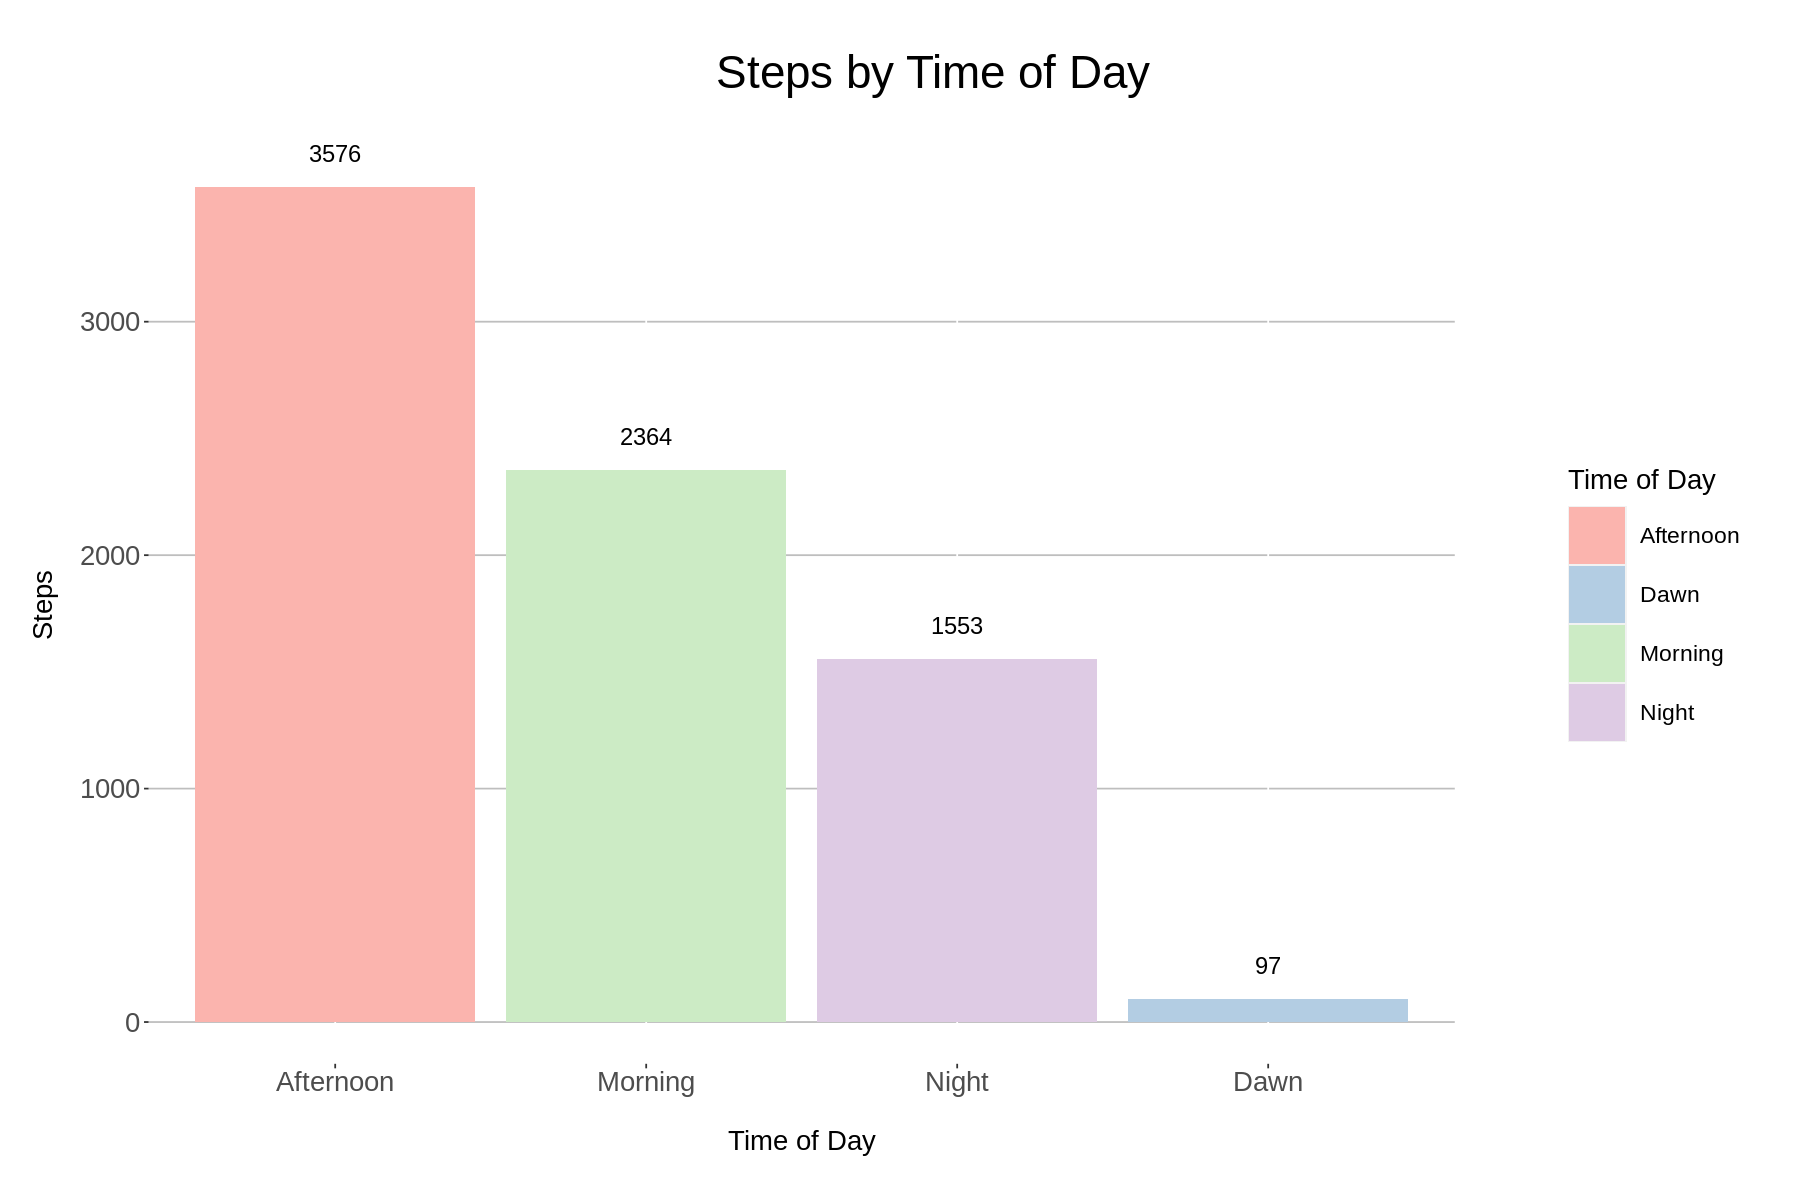

In [60]:
# Steps By Time of Day
ggplot(df_agg_tod_steps, aes(x = reorder(TimeOfDay, -Avg), y = Avg, fill = TimeOfDay)) +
  scale_fill_brewer(palette = "Pastel1") +
  geom_bar(stat = "identity") +
  labs(title = "Steps by Time of Day",
       x = "Time of Day",
       y = "Steps") +
  geom_text(aes(label = round(Avg)), vjust = -1.5, size = 5) +
  guides(fill = guide_legend(title = "Time of Day")) +
  theme(legend.key.size = unit(1.25, 'cm'),
        legend.text = element_text(size = rel(1.25)),
        legend.title = element_text(size = rel(1.5)),
        legend.margin = margin(0, 1, 0, 2, 'cm'),
        plot.title = element_text(size = rel(2.5), hjust = 0.65, margin = margin(1, 0, 1, 0, 'cm')),
        axis.text = element_text(size = rel(1.5)),
        axis.title.x = element_text(size = rel(1.5), margin = margin(0.75, 0, 0.75, 0, 'cm')),
        axis.title.y = element_text(size = rel(1.5), margin = margin(0, 0.5, 0, 0.5, 'cm')),
        panel.grid.major.y = element_line(colour='grey'),
        panel.background  = element_blank())

The same behavior is shown, with maximum activity throughout the afternoon and minimum activity at dawn.

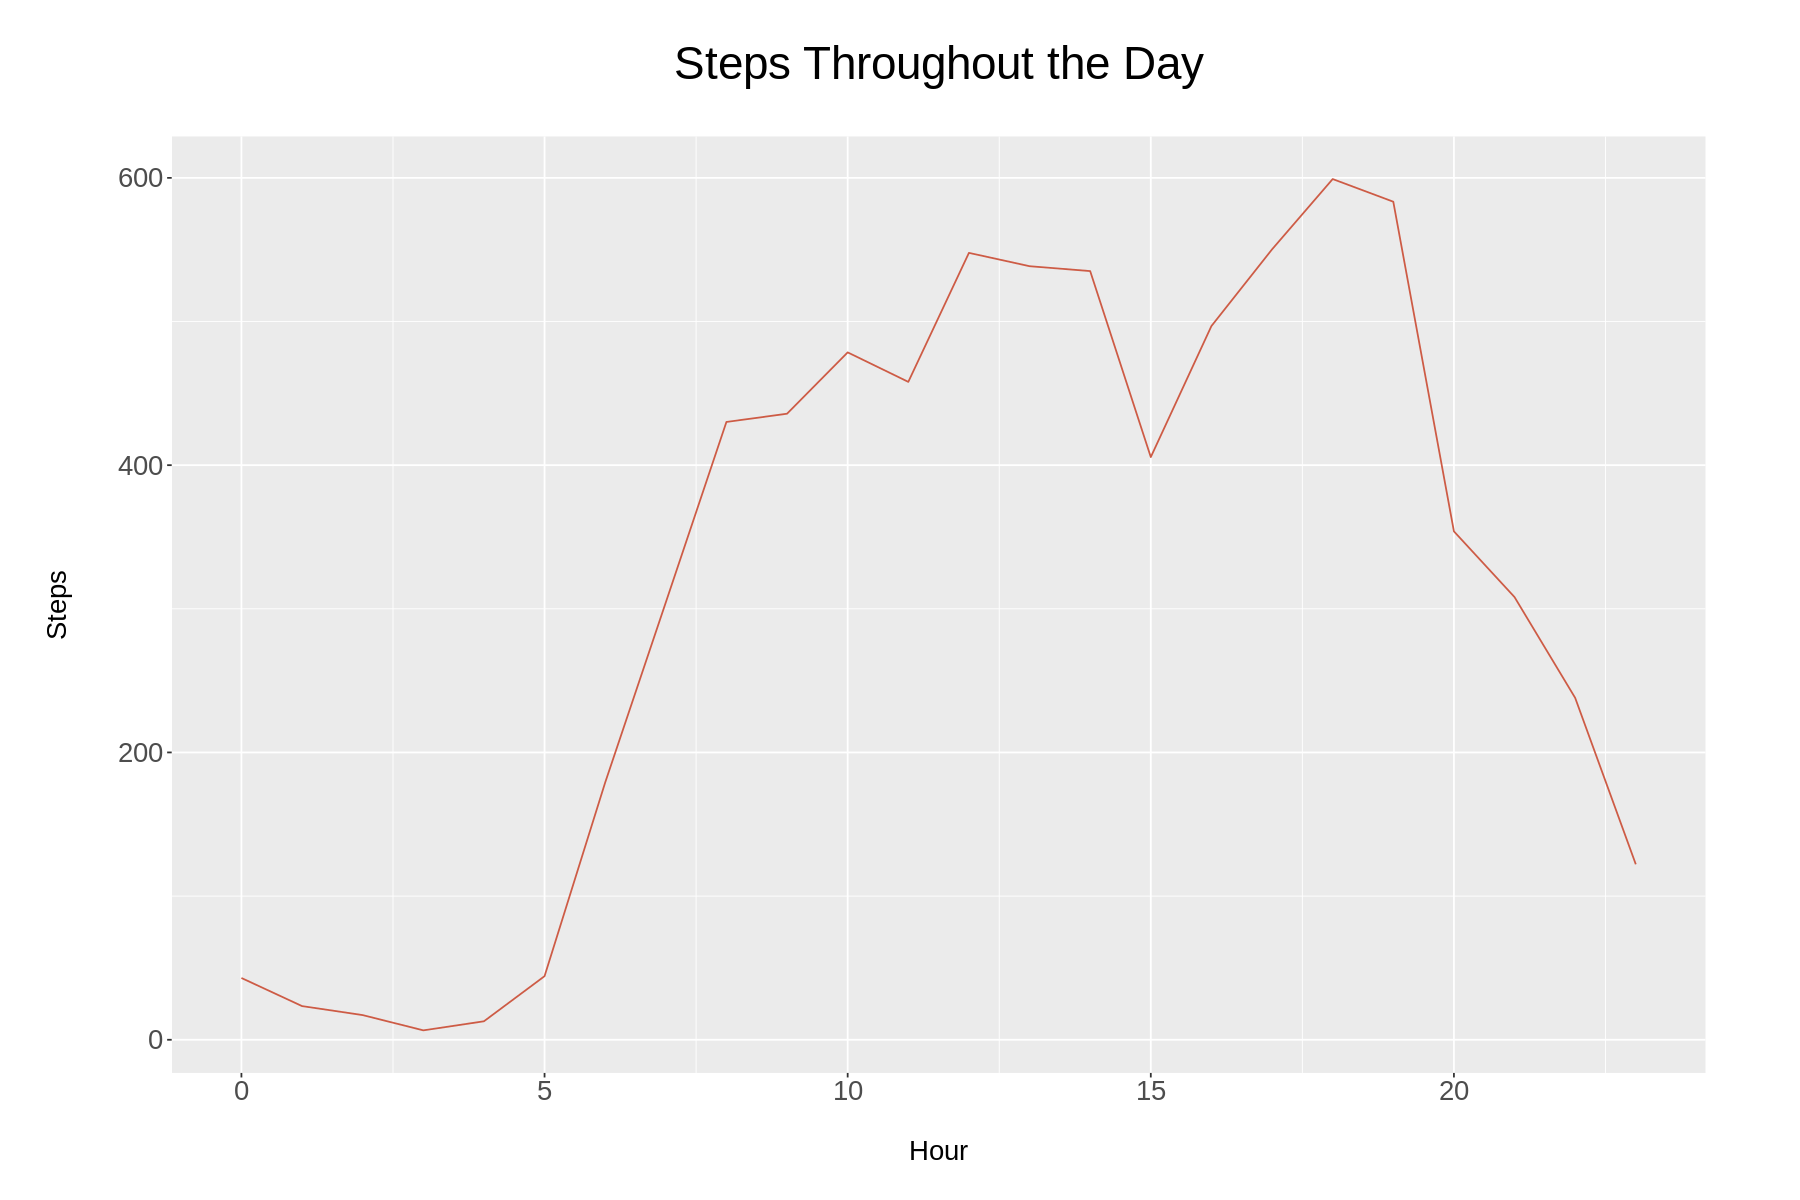

In [61]:
# Steps Throughout the Day
ggplot(df_agg_hour_steps, aes(x = Hour, y = HourAvg)) +
  geom_line(col='coral3') +
  labs(title = "Steps Throughout the Day",
       x = "Hour",
       y = "Steps") +
  theme(legend.key.size = unit(1.25, 'cm'),
        legend.text = element_text(size = rel(1.25)),
        legend.title = element_text(size = rel(1.5)),
        plot.title = element_text(size = rel(2.5), hjust = 0.5, margin = margin(1, 0, 1, 0, 'cm')),
        axis.text = element_text(size = rel(1.5)),
        axis.title.x = element_text(size = rel(1.5), margin = margin(0.75, 0, 0.75, 0, 'cm')),
        axis.title.y = element_text(size = rel(1.5), margin = margin(0, 1, 0, 1, 'cm')),
        plot.margin = margin(0, 2, 0, 0, 'cm'))

In [62]:
head(df_agg_hour_steps[order(-df_agg_hour_steps$HourAvg), ], n=10)

Hour,HourAvg,Sum,Min,Max,Stdev,Q25,Median,Q75,Range
<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
18,599.1700,542848,0,8586,897.4259,59.50,323,697.5,8586
19,583.3907,528552,0,7643,990.4490,58.00,254,651.0,7643
17,550.2329,498511,0,9062,908.3664,65.00,304,656.5,9062
12,547.7745,497927,0,8043,866.0482,66.00,269,607.0,8043
13,538.5017,489498,0,6745,834.2327,26.00,267,637.0,6745
14,535.0957,486402,0,10554,939.0592,25.00,234,597.0,10554
16,496.8456,450639,0,9392,805.0147,37.00,268,655.0,9392
10,478.5077,436399,0,6715,762.6564,0.00,218,592.5,6715
11,457.9770,417675,0,7652,702.3458,30.75,252,571.5,7652


These results indicate that there is a peak of physical activity around 5 to 7 PM. This is probably a time when users go for a walk, exercise, or commute back from work actively.

#### Heartrate

In [65]:
df_hrt <- database[['heartrate']]
head(df_hrt)

Id,Time,Value
<int64>,<chr>,<int>
2022484408,4/12/2016 7:21:00 AM,97
2022484408,4/12/2016 7:21:05 AM,102
2022484408,4/12/2016 7:21:10 AM,105
2022484408,4/12/2016 7:21:20 AM,103
2022484408,4/12/2016 7:21:25 AM,101
2022484408,4/12/2016 7:22:05 AM,95


In [66]:
# Formatting the dataset
df_hour_hrt <- df_hrt %>%
  mutate(Datetime = mdy_hms(Time),
    Date = format(Datetime, "%m/%d/%Y"),
    ActivityHour = format(floor_date(Datetime, "hour"), "%m/%d/%Y %I:%M:%S %p")) %>%
  group_by(Id, ActivityHour) %>%
  summarise(
    AvgHeartrate = mean(Value),
    .groups = "drop"
  )

head(df_hour_hrt)

Id,ActivityHour,AvgHeartrate
<int64>,<chr>,<dbl>
2022484408,04/12/2016 01:00:00 PM,83.68750
2022484408,04/12/2016 02:00:00 PM,80.57709
2022484408,04/12/2016 03:00:00 PM,68.32692
2022484408,04/12/2016 04:00:00 PM,71.02163
2022484408,04/12/2016 05:00:00 PM,69.94104
2022484408,04/12/2016 06:00:00 PM,76.37302


In [67]:
df_hour_hrt <- format_hour_dataset(df_hour_hrt, 'ActivityHour')
head(df_hour_hrt)

Id,ActivityHour,AvgHeartrate,Date,Hour,TimeOfDay
<int64>,<dttm>,<dbl>,<chr>,<dbl>,<chr>
2022484408,2016-04-12 13:00:00,83.68750,04/12/2016,13,Afternoon
2022484408,2016-04-12 14:00:00,80.57709,04/12/2016,14,Afternoon
2022484408,2016-04-12 15:00:00,68.32692,04/12/2016,15,Afternoon
2022484408,2016-04-12 16:00:00,71.02163,04/12/2016,16,Afternoon
2022484408,2016-04-12 17:00:00,69.94104,04/12/2016,17,Afternoon
2022484408,2016-04-12 18:00:00,76.37302,04/12/2016,18,Afternoon


In [68]:
# Checking for integrity
df_hour_hrt %>%
  group_by(Date) %>%
  summarise(Hours = n_distinct(Hour)) %>%
  arrange(Hours)

Date,Hours
<chr>,<int>
05/12/2016,17
04/12/2016,24
04/13/2016,24
04/14/2016,24
04/15/2016,24
04/16/2016,24
04/17/2016,24
04/18/2016,24
04/19/2016,24


In [69]:
# Removing incomplete records
df_hour_hrt <- df_hour_hrt %>%
  filter(!(Date %in% c('05/12/2016')))

In [70]:
df_agg_hour_hrt <- summarise_hour(df_hour_hrt, AvgHeartrate)
df_agg_hour_hrt

Hour,HourAvg,Sum,Min,Max,Stdev,Q25,Median,Q75,Range
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,66.44820,12425.81,47.71290,116.87500,11.593211,57.53314,65.33668,73.40577,69.16210
1,64.57333,11687.77,47.31176,119.56089,10.068692,57.13057,63.52093,69.68843,72.24912
2,62.79235,10800.28,47.58480,121.81173,9.736144,56.57331,62.99183,66.84969,74.22694
3,60.95743,10301.81,43.35404,86.86364,7.884324,56.24585,61.90584,65.37318,43.50960
4,60.47259,10159.39,44.10241,96.00000,7.902816,55.46155,61.06310,64.90108,51.89759
5,63.52751,11307.90,45.94659,116.51136,10.273994,58.20227,61.90200,66.47697,70.56478
6,73.87192,16990.54,47.69436,118.02206,14.215807,63.28125,70.64184,81.40584,70.32770
7,75.09828,19225.16,48.26531,115.15235,12.674091,66.18479,72.84399,82.38617,66.88705
8,76.07003,20919.26,53.98270,132.06263,15.072820,64.73964,72.70380,84.21334,78.07993


In [71]:
df_agg_tod_hrt <- df_hour_hrt %>%
    group_by(TimeOfDay) %>%
    summarise(Avg = mean(AvgHeartrate),
              Sum = sum(AvgHeartrate),
              Min = min(AvgHeartrate),
              Max = max(AvgHeartrate),
              Stdev = sd(AvgHeartrate),
              Q25 = quantile(AvgHeartrate, probs = 0.25, na.rm = TRUE),
              Median = median(AvgHeartrate),
              Q75 = quantile(AvgHeartrate, probs = 0.75, na.rm = TRUE),
              Range = max(AvgHeartrate) - min(AvgHeartrate),
              .groups = 'drop'
    )
df_agg_tod_hrt

TimeOfDay,Avg,Sum,Min,Max,Stdev,Q25,Median,Q75,Range
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Afternoon,79.59379,161177.42,48.08723,161.5073,14.746268,69.42670,77.25485,87.92162,113.42005
Dawn,63.14147,55375.07,43.35404,121.8117,9.837106,56.74286,62.68923,67.61652,78.45769
Morning,75.43041,137358.78,45.94659,132.0626,14.718246,63.87658,72.35252,84.30769,86.11604
Night,74.63818,91655.68,47.81847,159.6667,12.621037,65.93551,73.10694,81.34735,111.84820


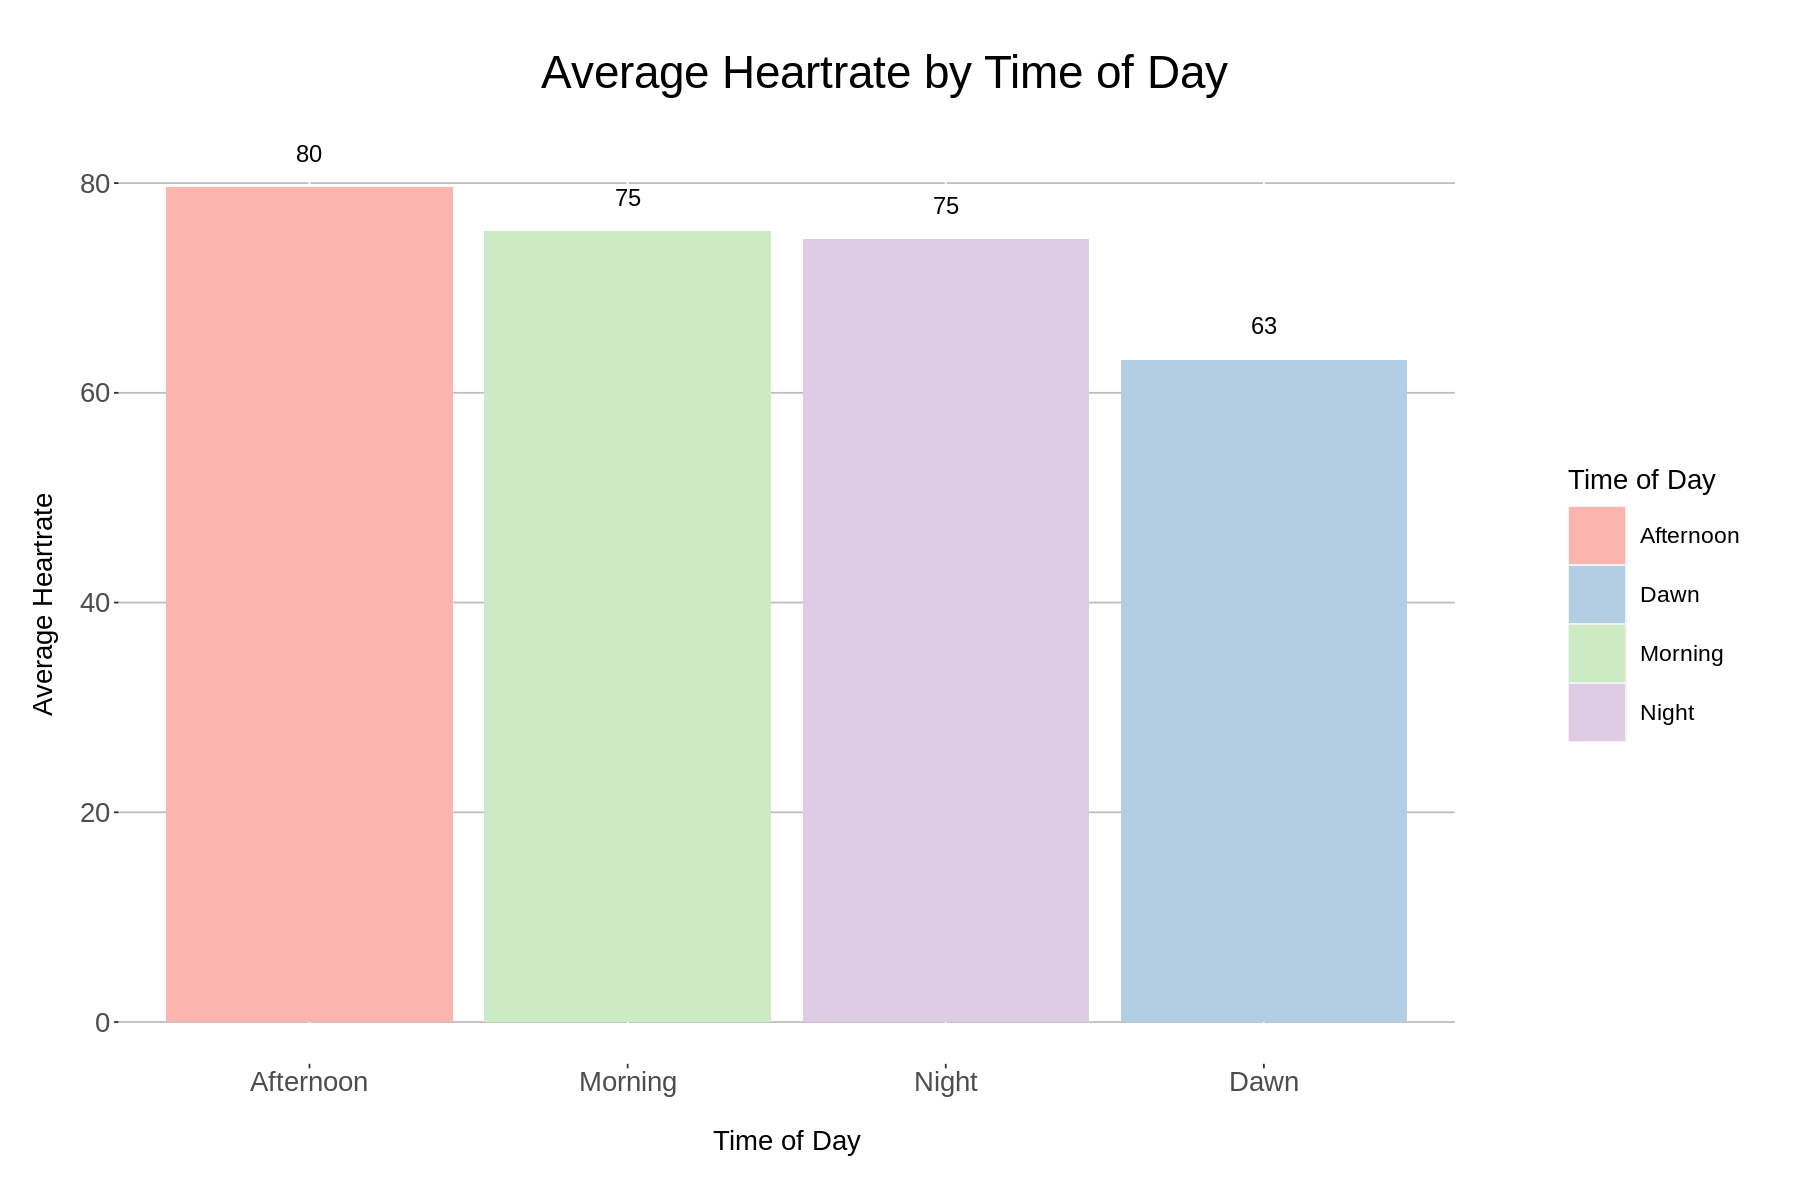

In [72]:
# Heartrate By Time of Day
ggplot(df_agg_tod_hrt, aes(x = reorder(TimeOfDay, -Avg), y = Avg, fill = TimeOfDay)) +
  scale_fill_brewer(palette = "Pastel1") +
  geom_bar(stat = "identity") +
  labs(title = "Average Heartrate by Time of Day",
       x = "Time of Day",
       y = "Average Heartrate") +
  geom_text(aes(label = round(Avg)), vjust = -1.5, size = 5) +
  guides(fill = guide_legend(title = "Time of Day")) +
  theme(legend.key.size = unit(1.25, 'cm'),
        legend.text = element_text(size = rel(1.25)),
        legend.title = element_text(size = rel(1.5)),
        legend.margin = margin(0, 1, 0, 2, 'cm'),
        plot.title = element_text(size = rel(2.5), hjust = 0.65, margin = margin(1, 0, 1, 0, 'cm')),
        axis.text = element_text(size = rel(1.5)),
        axis.title.x = element_text(size = rel(1.5), margin = margin(0.75, 0, 0.75, 0, 'cm')),
        axis.title.y = element_text(size = rel(1.5), margin = margin(0, 0.5, 0, 0.5, 'cm')),
        panel.grid.major.y = element_line(colour='grey'),
        panel.background  = element_blank())

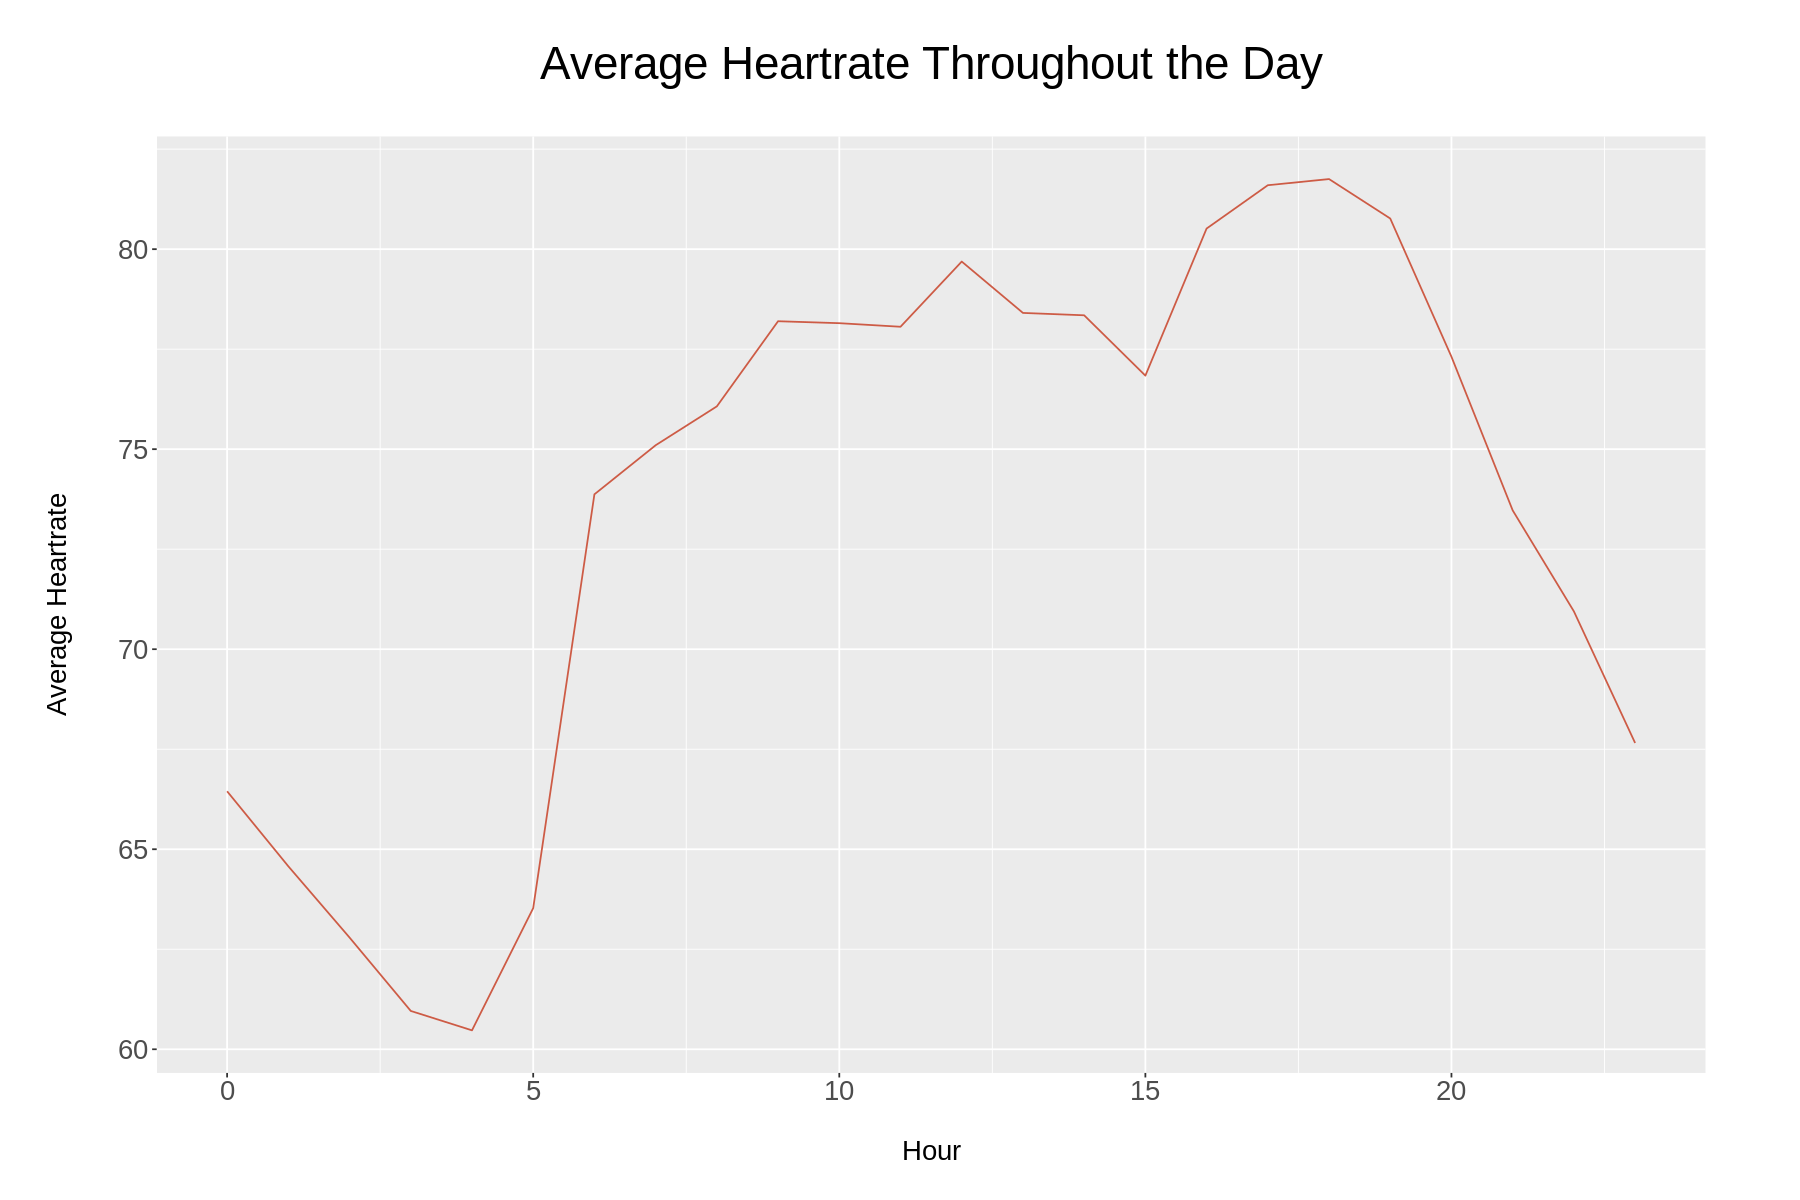

In [73]:
# Average Heartrate Throughout the Day
ggplot(df_agg_hour_hrt, aes(x = Hour, y = HourAvg)) +
  geom_line(col='coral3') +
  labs(title = "Average Heartrate Throughout the Day",
       x = "Hour",
       y = "Average Heartrate") +
  theme(legend.key.size = unit(1.25, 'cm'),
        legend.text = element_text(size = rel(1.25)),
        legend.title = element_text(size = rel(1.5)),
        plot.title = element_text(size = rel(2.5), hjust = 0.5, margin = margin(1, 0, 1, 0, 'cm')),
        axis.text = element_text(size = rel(1.5)),
        axis.title.x = element_text(size = rel(1.5), margin = margin(0.75, 0, 0.75, 0, 'cm')),
        axis.title.y = element_text(size = rel(1.5), margin = margin(0, 1, 0, 1, 'cm')),
        plot.margin = margin(0, 2, 0, 0, 'cm'))

In [74]:
head(df_agg_hour_hrt[order(-df_agg_hour_hrt$HourAvg), ], n=10)

Hour,HourAvg,Sum,Min,Max,Stdev,Q25,Median,Q75,Range
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,81.75205,23708.09,48.08723,157.6879,14.48735,72.67299,80.16914,88.24984,109.60072
17,81.59792,23255.41,50.57367,161.5073,14.80440,71.42009,79.41606,89.64394,110.93361
19,80.76564,22937.44,47.90746,127.3522,12.74250,72.12745,79.18901,87.89097,79.44476
16,80.51501,23349.35,52.69969,159.2480,15.44331,69.56098,77.02251,88.92872,106.54831
12,79.68962,23349.06,53.80757,148.0720,14.49010,69.57349,77.04167,86.93705,94.26439
13,78.40579,23051.30,54.67155,150.2062,15.08000,67.91889,76.19720,86.52580,95.53465
14,78.34657,22642.16,53.04720,160.0028,14.93929,67.48042,76.04816,87.83224,106.95563
9,78.19813,22912.05,52.06024,128.6919,16.29072,64.44536,75.36061,88.16055,76.63162
10,78.14939,23210.37,55.89344,127.4405,15.00132,65.32648,75.78454,86.67638,71.54706


In [75]:
head(df_agg_hour_hrt[order(df_agg_hour_hrt$HourAvg), ], n=10)

Hour,HourAvg,Sum,Min,Max,Stdev,Q25,Median,Q75,Range
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4,60.47259,10159.39,44.10241,96.00000,7.902816,55.46155,61.06310,64.90108,51.89759
3,60.95743,10301.81,43.35404,86.86364,7.884324,56.24585,61.90584,65.37318,43.50960
2,62.79235,10800.28,47.58480,121.81173,9.736144,56.57331,62.99183,66.84969,74.22694
5,63.52751,11307.90,45.94659,116.51136,10.273994,58.20227,61.90200,66.47697,70.56478
1,64.57333,11687.77,47.31176,119.56089,10.068692,57.13057,63.52093,69.68843,72.24912
0,66.44820,12425.81,47.71290,116.87500,11.593211,57.53314,65.33668,73.40577,69.16210
23,67.65562,13260.50,47.81847,112.65848,11.153752,60.11294,66.15106,73.66432,64.84001
22,70.94545,15678.94,50.24038,159.66667,12.764852,62.95469,69.50633,76.70077,109.42628
21,73.47062,18441.12,54.98209,112.60000,10.549894,66.07780,72.55056,77.96357,57.61791


As observed, the average heart rate is lower at dawn - typically when people are asleep - and increases during moments of intense physical activity.

#### Complete Analysis

In [76]:
colnames(df_agg_hour_cal)[colnames(df_agg_hour_cal) == "HourAvg"] <- "AvgCalories"
colnames(df_agg_hour_int)[colnames(df_agg_hour_int) == "HourAvg"] <- "AvgIntensity"
colnames(df_agg_hour_steps)[colnames(df_agg_hour_steps) == "HourAvg"] <- "AvgSteps"
colnames(df_agg_hour_hrt)[colnames(df_agg_hour_hrt) == "HourAvg"] <- "AvgHeartrate"

In [77]:
df_hour <- merge(df_agg_hour_cal[, c("Hour", "AvgCalories")], df_agg_hour_int[, c("Hour", "AvgIntensity")], by="Hour", all.x=TRUE)
df_hour <- merge(df_hour, df_agg_hour_steps[, c("Hour", "AvgSteps")], by="Hour", all.x=TRUE)
df_hour <- merge(df_hour, df_agg_hour_hrt[, c("Hour", "AvgHeartrate")], by="Hour", all.x=TRUE)
df_hour

Hour,AvgCalories,AvgIntensity,AvgSteps,AvgHeartrate
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,71.91148,2.1661202,42.990164,66.44820
1,70.22538,1.4354486,23.422319,64.57333
2,69.22429,1.0503282,17.159737,62.79235
3,67.56127,0.4485777,6.543764,60.95743
4,68.27790,0.6356674,12.853392,60.47259
5,81.98140,5.0317287,44.268053,63.52751
6,87.08981,7.7973713,179.064622,73.87192
7,94.41512,10.7250821,304.450164,75.09828
8,103.49617,14.7119387,430.084337,76.07003


In [78]:
features = df_hour %>% select(c('AvgCalories', 'AvgIntensity', 'AvgSteps', 'AvgHeartrate'))
head(features)

,AvgCalories,AvgIntensity,AvgSteps,AvgHeartrate
,<dbl>,<dbl>,<dbl>,<dbl>
1,71.91148,2.1661202,42.990164,66.44820
2,70.22538,1.4354486,23.422319,64.57333
3,69.22429,1.0503282,17.159737,62.79235
4,67.56127,0.4485777,6.543764,60.95743
5,68.27790,0.6356674,12.853392,60.47259
6,81.98140,5.0317287,44.268053,63.52751


In [79]:
cor(features)

,AvgCalories,AvgIntensity,AvgSteps,AvgHeartrate
AvgCalories,1.0000000,0.9987308,0.9904672,0.9644364
AvgIntensity,0.9987308,1.0000000,0.9934482,0.9684146
AvgSteps,0.9904672,0.9934482,1.0000000,0.9663986
AvgHeartrate,0.9644364,0.9684146,0.9663986,1.0000000


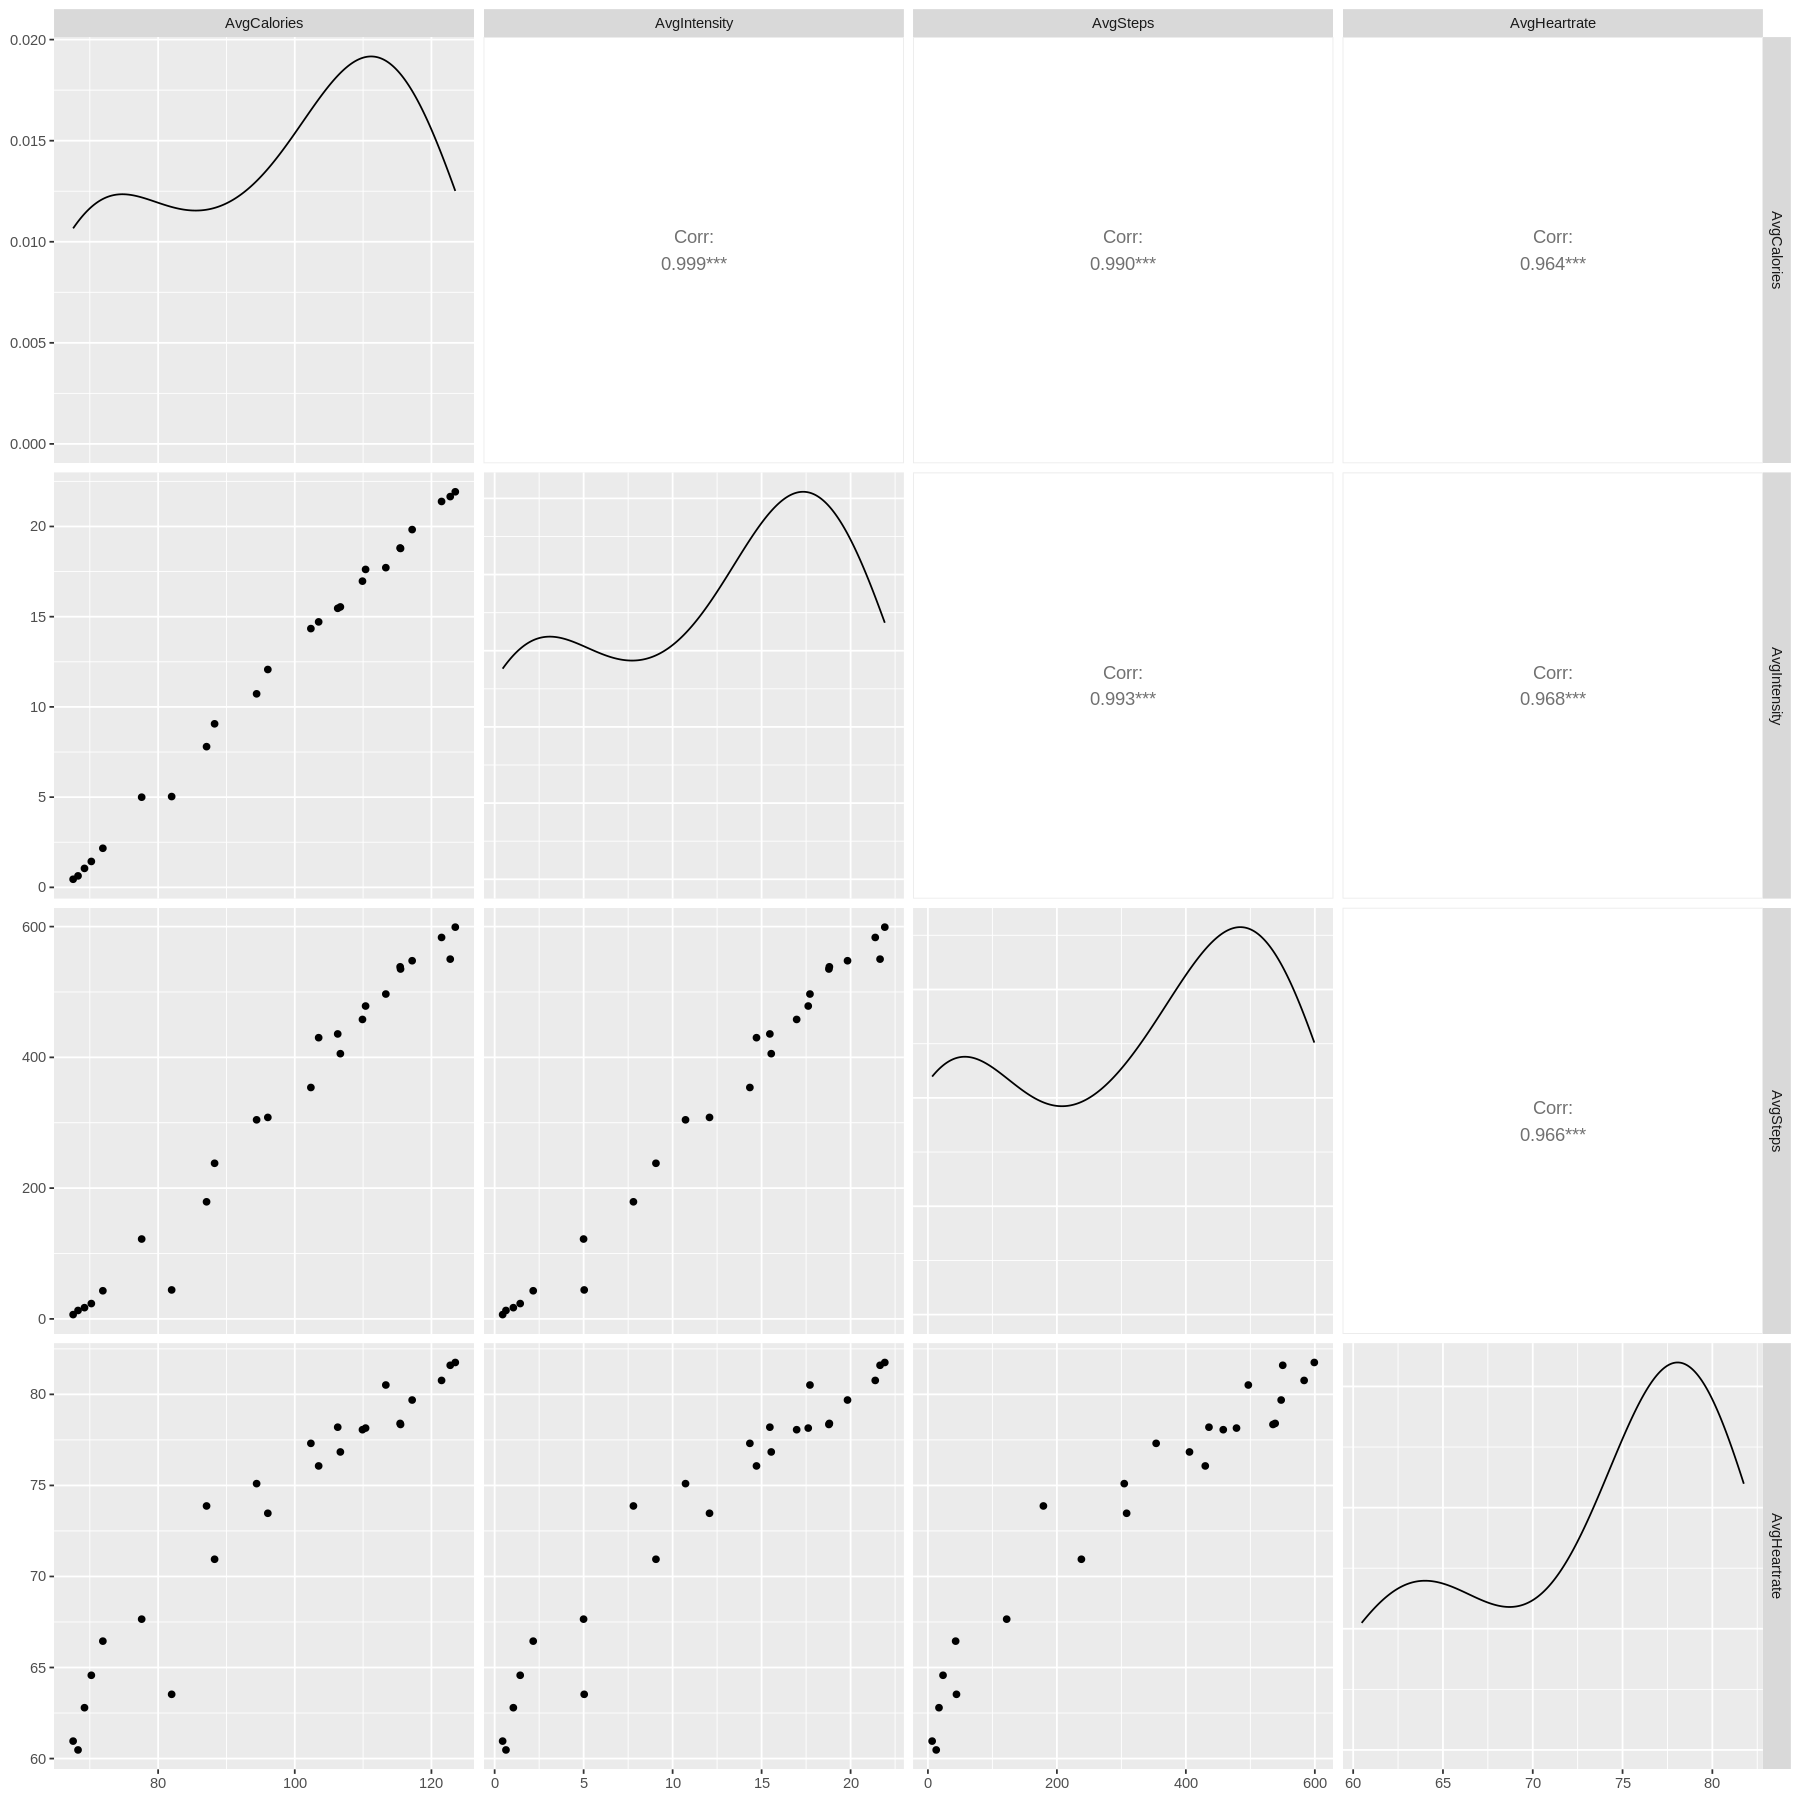

In [80]:
options(repr.plot.width = 15, repr.plot.height = 15)
ggpairs(features)

Ultimately, we observe a strong correlation among all the analyzed variables. These patterns can prove valuable in assisting users to establish fitness milestones by offering recommendations for activities and healthy habits to attain their goals.

### Daily Trends

Function for formatting data:

In [81]:
format_day_dataset <- function(df, day_col) {
  df$ActivityDate <- as.Date(df[[day_col]], format = "%m/%d/%Y")
  df <- df %>% mutate(
    DayOfWeek = weekdays(ActivityDate)
    )

  return(df)
}

#### Activity

In [82]:
df_activity <- database[['dailyActivity']]
head(df_activity)

Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
<int64>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>
1503960366,4/12/2016,13162,8.50,8.50,0,1.88,0.55,6.06,0,25,13,328,728,1985
1503960366,4/13/2016,10735,6.97,6.97,0,1.57,0.69,4.71,0,21,19,217,776,1797
1503960366,4/14/2016,10460,6.74,6.74,0,2.44,0.40,3.91,0,30,11,181,1218,1776
1503960366,4/15/2016,9762,6.28,6.28,0,2.14,1.26,2.83,0,29,34,209,726,1745
1503960366,4/16/2016,12669,8.16,8.16,0,2.71,0.41,5.04,0,36,10,221,773,1863
1503960366,4/17/2016,9705,6.48,6.48,0,3.19,0.78,2.51,0,38,20,164,539,1728


In [83]:
df_activity <- format_day_dataset(df_activity, "ActivityDate")
df_activity

Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,DayOfWeek
<int64>,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>
1503960366,2016-04-12,13162,8.50,8.50,0,1.88,0.55,6.06,0,25,13,328,728,1985,Tuesday
1503960366,2016-04-13,10735,6.97,6.97,0,1.57,0.69,4.71,0,21,19,217,776,1797,Wednesday
1503960366,2016-04-14,10460,6.74,6.74,0,2.44,0.40,3.91,0,30,11,181,1218,1776,Thursday
1503960366,2016-04-15,9762,6.28,6.28,0,2.14,1.26,2.83,0,29,34,209,726,1745,Friday
1503960366,2016-04-16,12669,8.16,8.16,0,2.71,0.41,5.04,0,36,10,221,773,1863,Saturday
1503960366,2016-04-17,9705,6.48,6.48,0,3.19,0.78,2.51,0,38,20,164,539,1728,Sunday
1503960366,2016-04-18,13019,8.59,8.59,0,3.25,0.64,4.71,0,42,16,233,1149,1921,Monday
1503960366,2016-04-19,15506,9.88,9.88,0,3.53,1.32,5.03,0,50,31,264,775,2035,Tuesday
1503960366,2016-04-20,10544,6.68,6.68,0,1.96,0.48,4.24,0,28,12,205,818,1786,Wednesday


In [84]:
df_day_activity <- df_activity %>%
  group_by(ActivityDate, DayOfWeek) %>%
  summarize(across(-c(Id), \(x) mean(x, na.rm = TRUE)),
  .groups = "drop"
)

df_day_activity

ActivityDate,DayOfWeek,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016-04-12,Tuesday,8236.848,5.982727,5.958182,0.21584436,1.8263636,0.3460606,3.410000,0.0003030303,22.303030,7.848485,199.00000,1026.2121,2390.697
2016-04-13,Wednesday,7198.727,5.103333,5.071515,0.21040770,1.3266667,0.4200000,3.140909,0.0015151515,20.333333,10.575758,181.75758,1021.7879,2286.636
2016-04-14,Thursday,7743.576,5.599394,5.576364,0.16783321,1.5096970,0.5096970,3.568485,0.0021212121,20.939394,12.393939,201.00000,1010.0303,2356.394
2016-04-15,Friday,7533.848,5.287879,5.287879,0.00000000,1.0557576,0.4039394,3.767273,0.0015151515,19.181818,9.878788,213.84848,961.0606,2355.182
2016-04-16,Saturday,8679.156,6.291563,6.291563,0.00000000,1.9937500,0.7087500,3.450625,0.0015625000,27.843750,15.125000,193.81250,1002.6562,2392.938
2016-04-17,Sunday,6409.250,4.540625,4.540625,0.00000000,1.1453125,0.4975000,2.822188,0.0006250000,18.906250,11.843750,165.34375,1049.9688,2230.969
2016-04-18,Monday,7896.969,5.657812,5.624375,0.21945929,1.6656250,0.6959375,3.281250,0.0015625000,24.406250,16.125000,188.28125,1061.2188,2333.375
2016-04-19,Tuesday,8048.656,5.871875,5.841250,0.22485072,1.8831250,0.5190625,3.463437,0.0009375000,23.968750,13.781250,201.90625,1003.9375,2359.094
2016-04-20,Wednesday,8162.969,5.950313,5.922188,0.21928088,1.8618750,0.6334375,3.450938,0.0018750000,24.187500,18.750000,203.59375,974.1250,2395.219


In [85]:
df_week_activity <- df_activity %>%
  group_by(DayOfWeek) %>%
  # Get full weeks
  filter(!(ActivityDate %in% c('2016-05-11', '2016-05-12'))) %>%
  summarize(across(-c(Id, ActivityDate), \(x) mean(x, na.rm = TRUE)))

df_week_activity

DayOfWeek,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Friday,7448.230,5.309921,5.302936,0.07218603,1.312937,0.4838095,3.489127,0.001825397,20.05556,12.11111,204.1984,1000.3095,2331.786
Monday,7780.867,5.552917,5.528750,0.22455211,1.537333,0.5858333,3.363083,0.002583333,23.10833,14.00000,192.0583,1027.9417,2324.208
Saturday,8152.976,5.854677,5.854677,0.00000000,1.514597,0.6773387,3.617177,0.001048387,21.91935,15.20161,207.1452,964.2823,2354.968
Sunday,6933.231,5.027190,5.027190,0.00000000,1.488926,0.6180165,2.892314,0.000661157,19.98347,14.52893,173.9752,990.2562,2263.000
Thursday,8059.754,5.790397,5.761429,0.15083002,1.561429,0.5726984,3.501270,0.002619048,21.94444,13.59524,199.8571,1013.6587,2376.286
Tuesday,8125.007,5.832237,5.812829,0.16905403,1.613289,0.5930263,3.471053,0.001447368,22.95395,14.33553,197.3421,1007.3618,2356.013
Wednesday,7566.968,5.487143,5.462460,0.14957180,1.638968,0.5055556,3.259048,0.001428571,20.69048,12.83333,190.8651,1008.7698,2324.056


In [87]:
categories  = c('VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes', 'SedentaryMinutes')
df_active_mean <- df_week_activity %>%
  select(all_of(categories)) %>%
  pivot_longer(cols = categories, names_to = "Category") %>%
  group_by(Category) %>%
  summarise(Mean = mean(value))

df_active_mean <- df_active_mean %>%
  mutate(Percentage = round((Mean / sum(Mean) * 100), 2))

df_active_mean <- df_active_mean[order(-df_active_mean$Mean), ]
df_active_mean

Category,Mean,Percentage
<chr>,<dbl>,<dbl>
SedentaryMinutes,1001.79715,81.30
LightlyActiveMinutes,195.06306,15.83
VeryActiveMinutes,21.52223,1.75
FairlyActiveMinutes,13.80082,1.12


##### Activity Minutes

In [88]:
options(repr.plot.width = 15, repr.plot.height = 10)

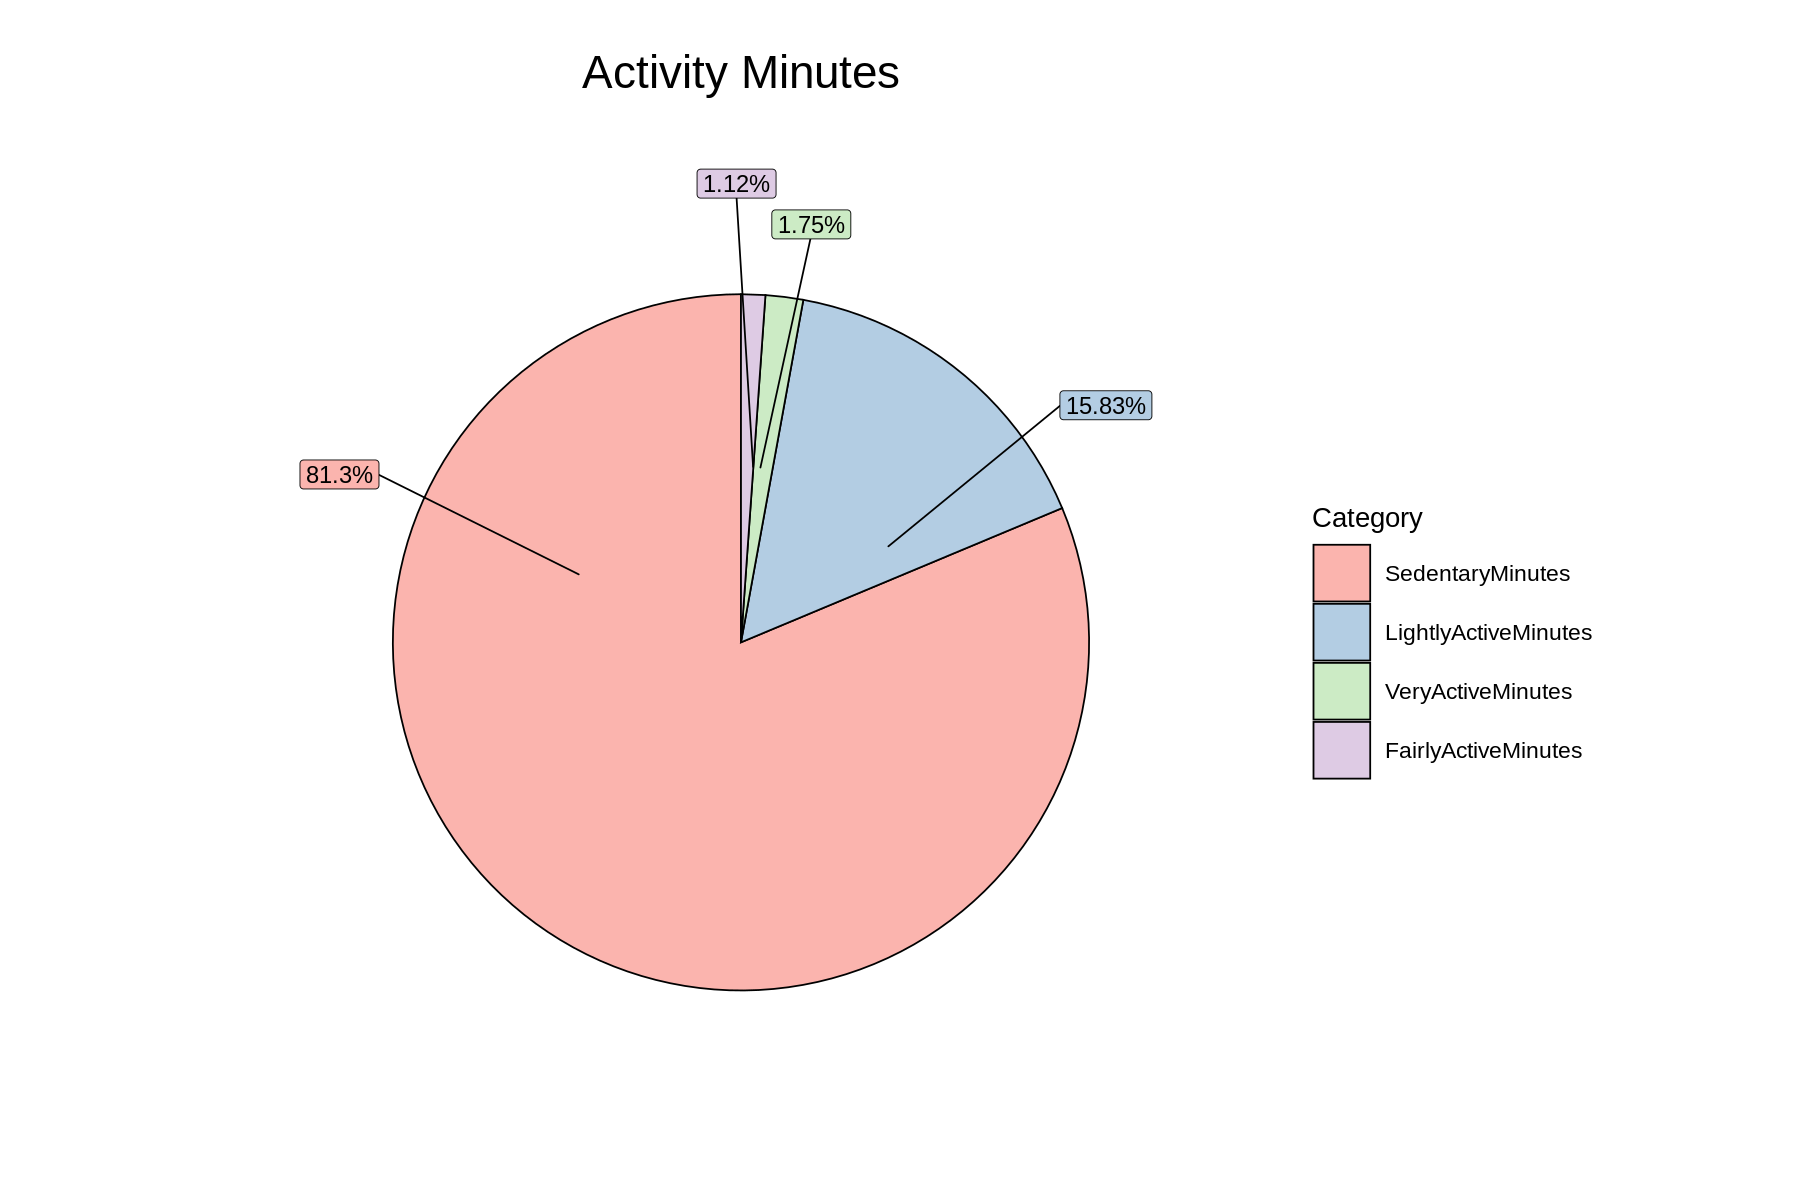

In [89]:
ggplot(df_active_mean, aes(x = "" , y = Mean, fill = fct_inorder(Category))) +
  geom_col(width = 1, color = 1) +
  coord_polar(theta = "y") +
  scale_fill_brewer(palette = "Pastel1") +
  geom_label_repel(data = df_active_mean,
                   aes(y = Mean, label = paste0(Percentage, "%")),
                   size = 5, nudge_x = 0.75, show.legend = FALSE) +
  guides(fill = guide_legend(title = "Category")) +
  theme(legend.key.size = unit(1.25, 'cm'),
        legend.text = element_text(size = rel(1.25)),
        legend.title = element_text(size = rel(1.5)),
        plot.title = element_text(size = rel(2.5), hjust = 0.5, margin = margin(1, 0, 0, 0, 'cm')),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        panel.background  = element_blank()) +
  labs(title = "Activity Minutes")

When analyzing activity minutes, it becomes clear that individuals spend a significant amount of time (81,3% on average) in a sedentary state.  

##### Calories

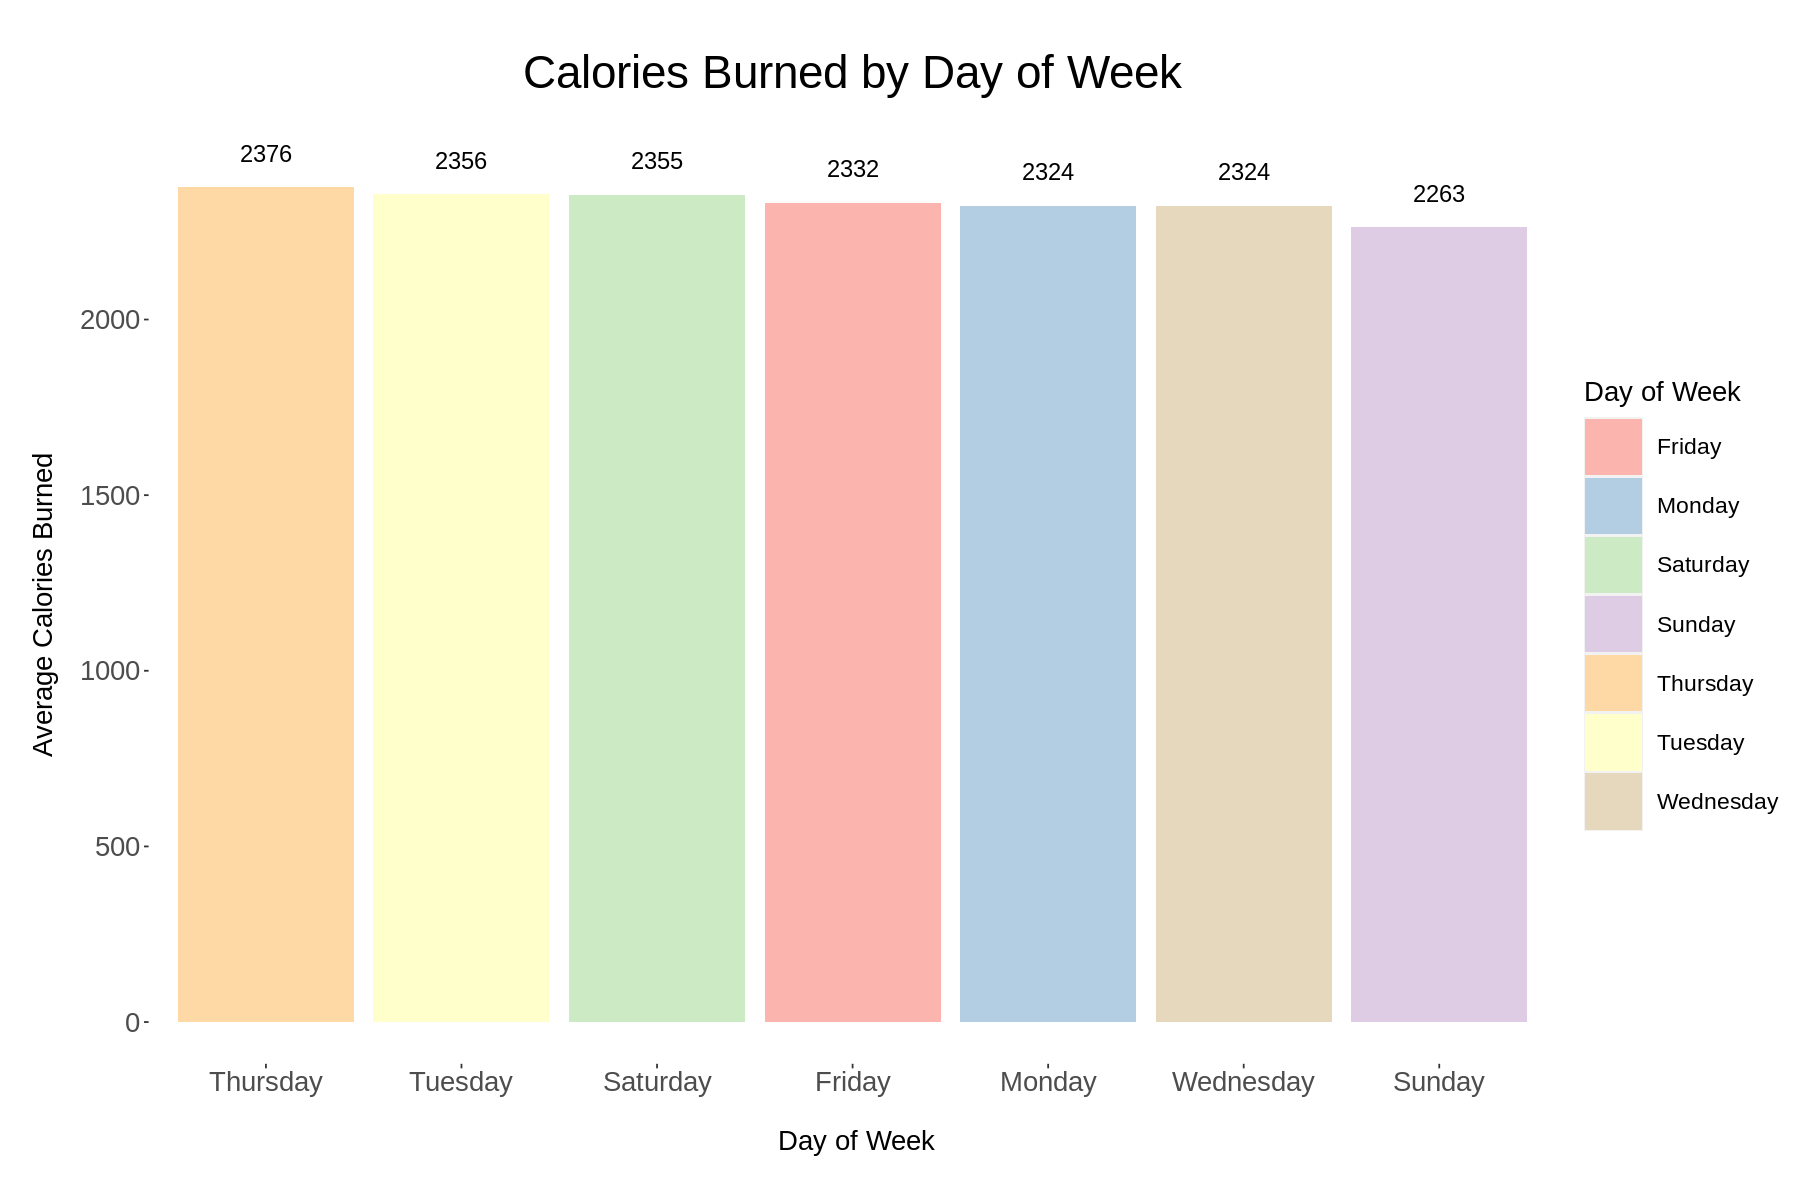

In [90]:
# Calories Burned By Day of Week
ggplot(df_week_activity, aes(x = reorder(DayOfWeek, -Calories), y = Calories, fill = DayOfWeek)) +
  scale_fill_brewer(palette = "Pastel1") +
  geom_bar(stat = "identity") +
  geom_text(aes(label = round(Calories)), vjust = -1.5, size = 5) +
  labs(title = "Calories Burned by Day of Week",
       x = " Day of Week",
       y = "Average Calories Burned") +
  guides(fill = guide_legend(title = "Day of Week")) +
  theme(legend.key.size = unit(1.25, 'cm'),
        legend.text = element_text(size = rel(1.25)),
        legend.title = element_text(size = rel(1.5)),
        plot.title = element_text(size = rel(2.5), hjust = 0.5, margin = margin(1, 0, 1, 0, 'cm')),
        axis.text = element_text(size = rel(1.5)),
        axis.title.x = element_text(size = rel(1.5), margin = margin(0.75, 0, 0.75, 0, 'cm')),
        axis.title.y = element_text(size = rel(1.5), margin = margin(0, 0.5, 0, 0.5, 'cm')),
        panel.background  = element_blank())

##### Steps

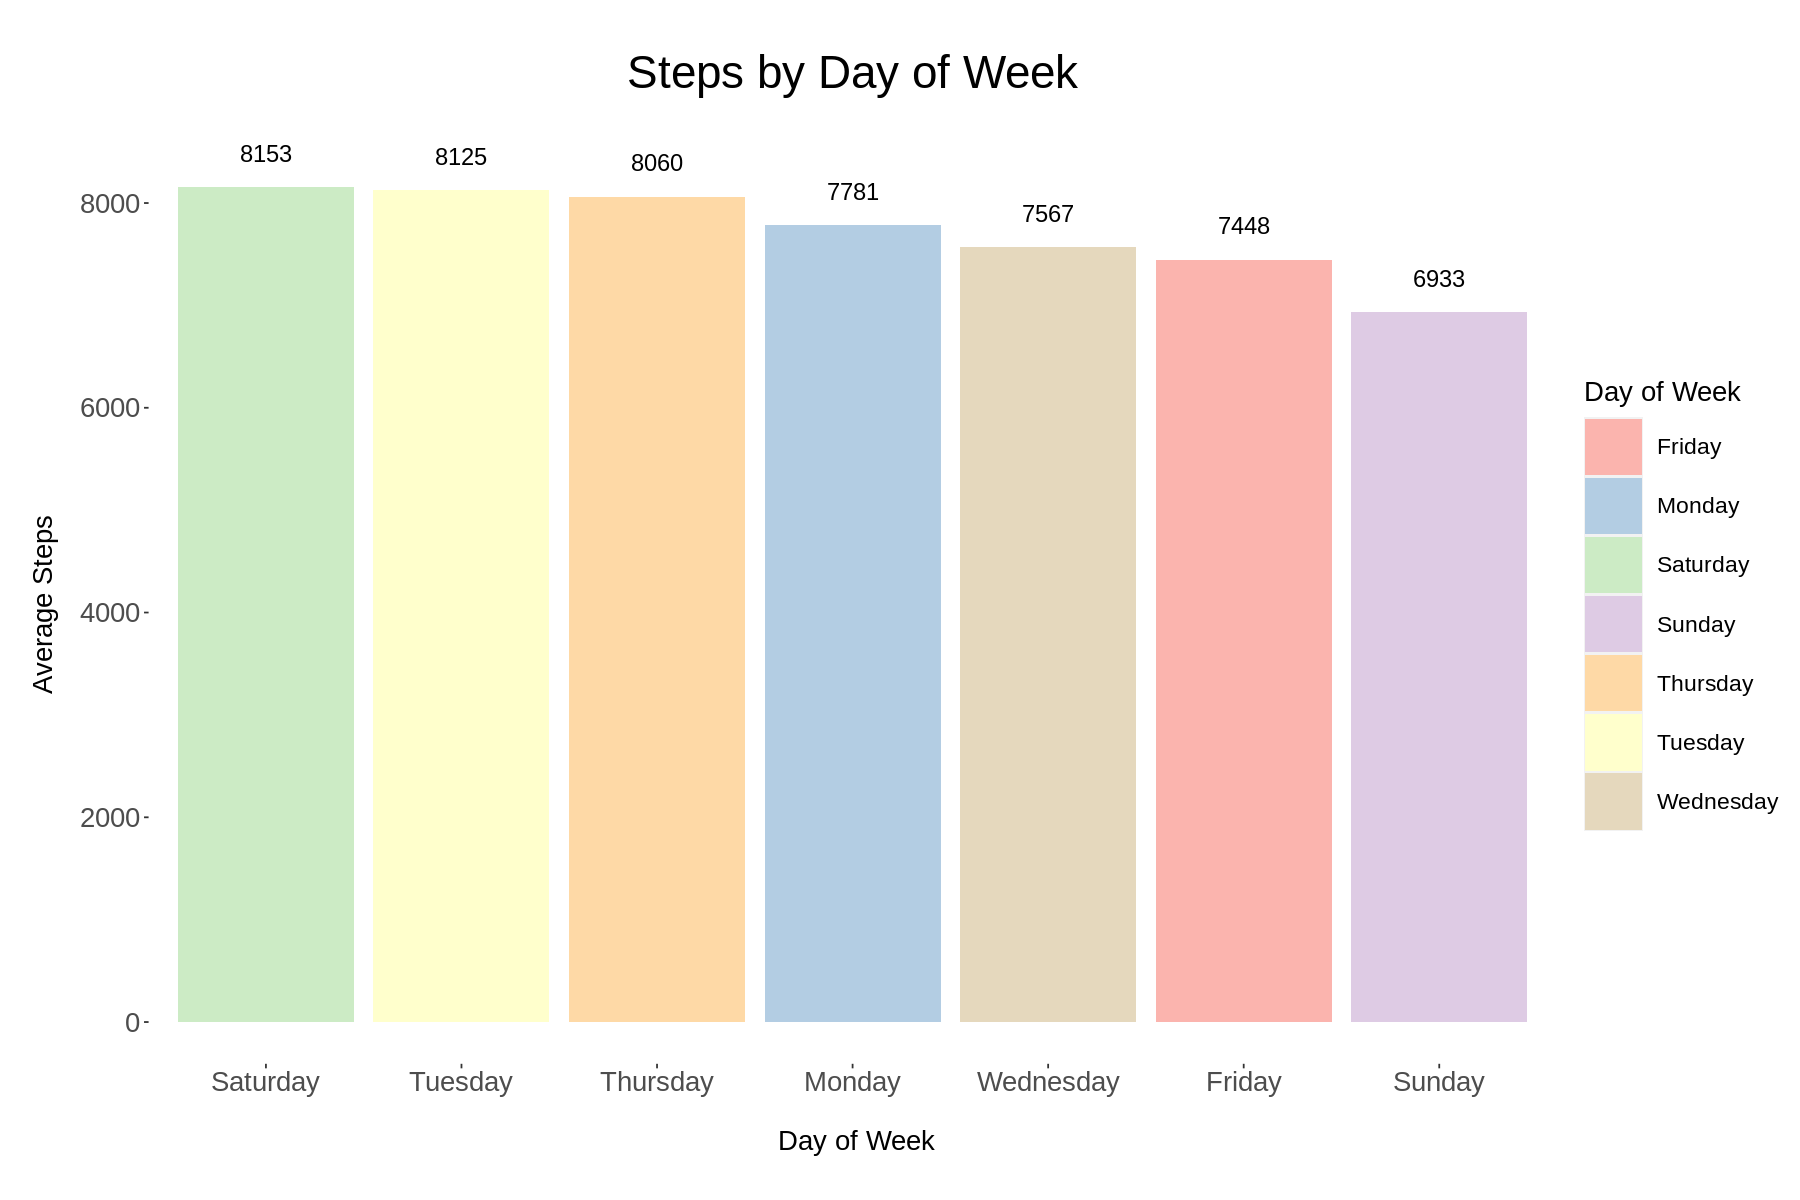

In [91]:
# Steps By Day of Week
ggplot(df_week_activity, aes(x = reorder(DayOfWeek, -TotalSteps), y = TotalSteps, fill = DayOfWeek)) +
  scale_fill_brewer(palette = "Pastel1") +
  geom_bar(stat = "identity") +
  geom_text(aes(label = round(TotalSteps)), vjust = -1.5, size = 5) +
  labs(title = "Steps by Day of Week",
       x = " Day of Week",
       y = "Average Steps") +
  guides(fill = guide_legend(title = "Day of Week")) +
  theme(legend.key.size = unit(1.25, 'cm'),
        legend.text = element_text(size = rel(1.25)),
        legend.title = element_text(size = rel(1.5)),
        plot.title = element_text(size = rel(2.5), hjust = 0.5, margin = margin(1, 0, 1, 0, 'cm')),
        axis.text = element_text(size = rel(1.5)),
        axis.title.x = element_text(size = rel(1.5), margin = margin(0.75, 0, 0.75, 0, 'cm')),
        axis.title.y = element_text(size = rel(1.5), margin = margin(0, 0.5, 0, 0.5, 'cm')),
        panel.background  = element_blank())

Both results indicate that people burn fewer calories and take fewer steps on Sundays, suggesting lower activity levels on this day.

##### Distance

In [92]:
categories  = c('VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance')
df_distance_mean <- df_week_activity %>%
  select(all_of(categories)) %>%
  pivot_longer(cols = categories, names_to = "Category") %>%
  group_by(Category) %>%
  summarise(Mean = mean(value))

df_distance_mean <- df_distance_mean %>%
  mutate(Percentage = round((Mean / sum(Mean) * 100), 2))

df_distance_mean <- df_distance_mean[order(-df_distance_mean$Mean), ]
df_distance_mean

Category,Mean,Percentage
<chr>,<dbl>,<dbl>
LightActiveDistance,3.370438839,61.59
VeryActiveDistance,1.523925505,27.85
ModeratelyActiveDistance,0.576611195,10.54
SedentaryActiveDistance,0.001659037,0.03


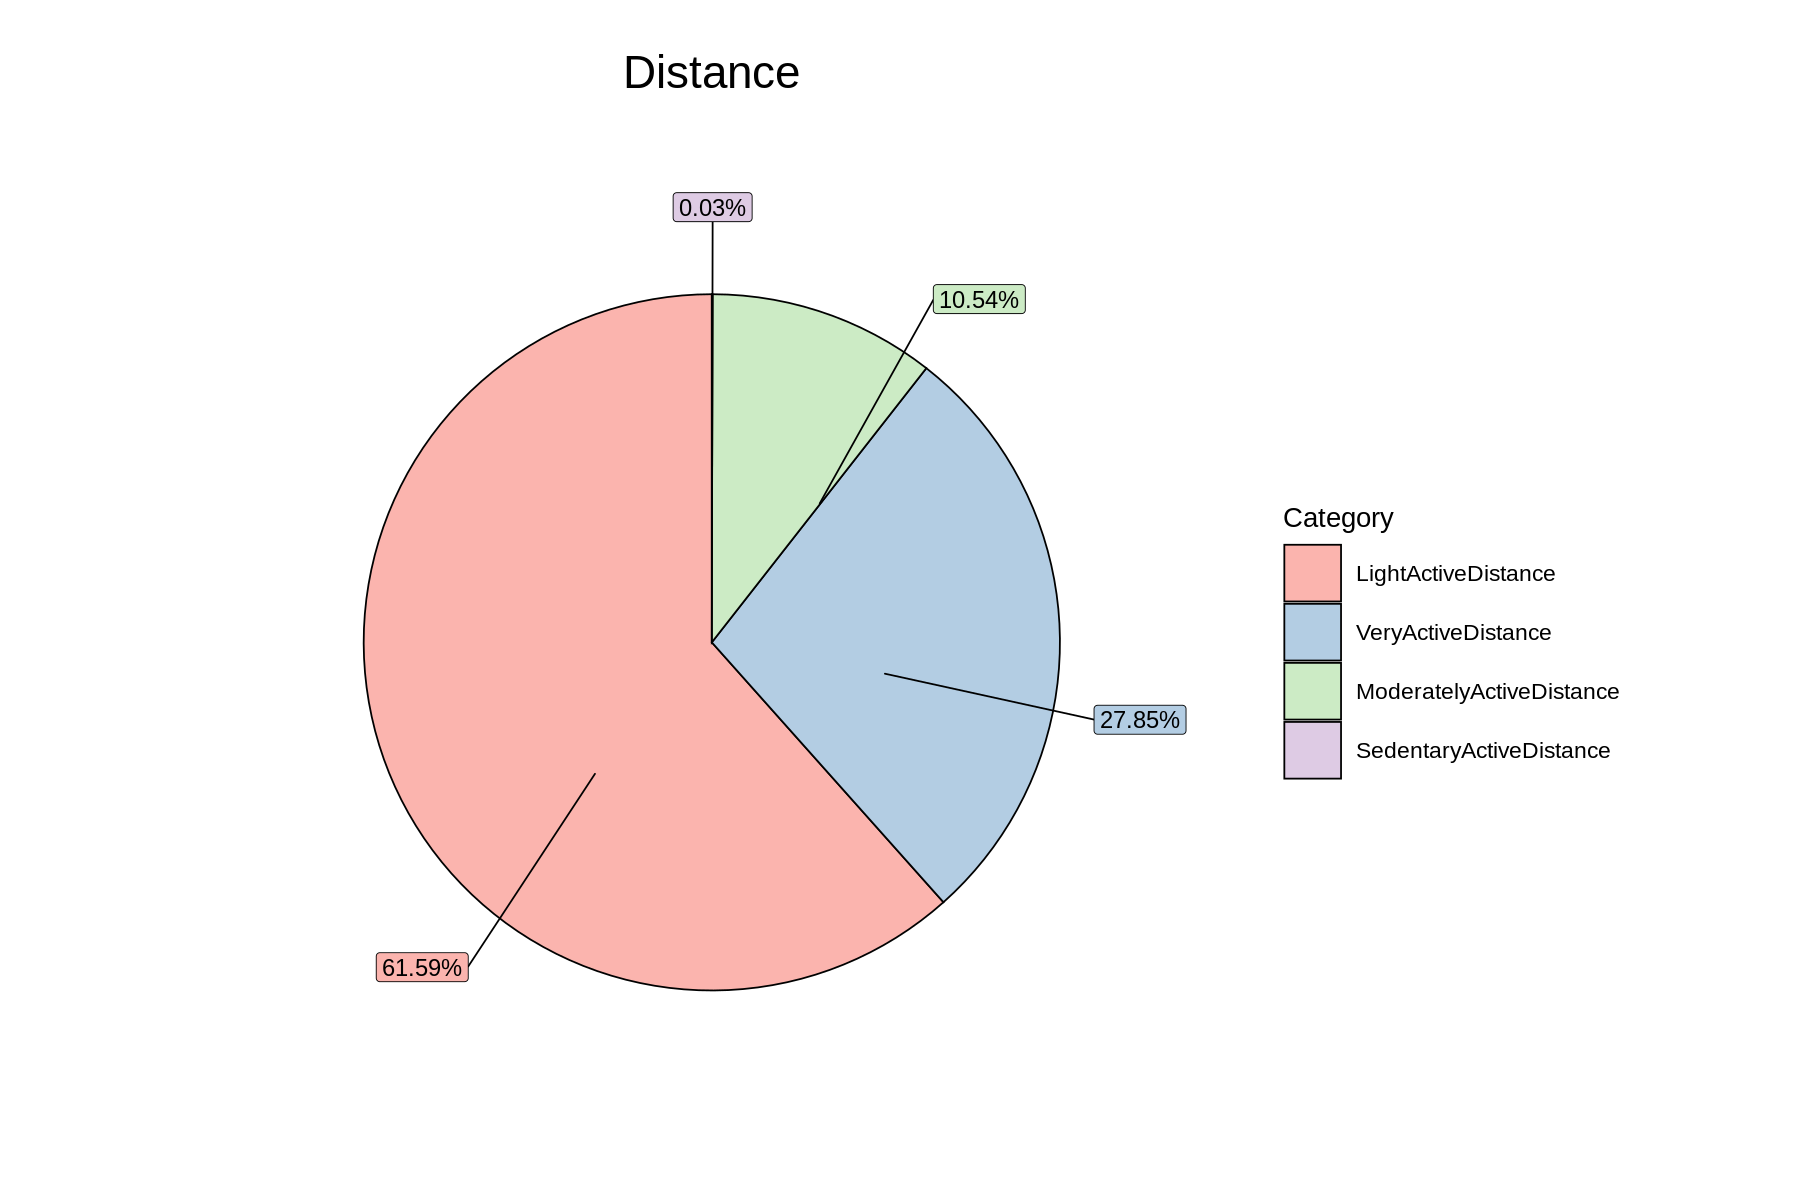

In [93]:
# Distance
ggplot(df_distance_mean, aes(x = "" , y = Mean, fill = fct_inorder(Category))) +
  geom_col(width = 1, color = 1) +
  coord_polar(theta = "y") +
  scale_fill_brewer(palette = "Pastel1") +
  geom_label_repel(data = df_distance_mean,
                   aes(y = Mean, label = paste0(Percentage, "%")),
                   size = 5, nudge_x = 0.75, show.legend = FALSE) +
  guides(fill = guide_legend(title = "Category")) +
  theme(legend.key.size = unit(1.25, 'cm'),
        legend.text = element_text(size = rel(1.25)),
        legend.title = element_text(size = rel(1.5)),
        plot.title = element_text(size = rel(2.5), hjust = 0.5, margin = margin(1, 0, 0, 0, 'cm')),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title.x = element_blank(),
        axis.title.y = element_blank(),
        panel.background  = element_blank()) +
  labs(title = "Distance")

The chart above indicates that people move greater distances while performing low-intensity activities, followed by high-intensity activities. This suggests that that a significant portion of their active time is spent walking or running. The insignificance of Sedentary Active Distance seems accurate, as sedentary people tend to remain still most of the time.

#### Weight

In [94]:
# This dataset has already been cleaned
head(df_weight)

Id,Date,WeightKg,WeightPounds,BMI,IsManualReport,LogId
<int64>,<chr>,<dbl>,<dbl>,<dbl>,<lgl>,<int64>
1503960366,5/2/2016 11:59:59 PM,52.6,115.9631,22.65,TRUE,1462233599000
1503960366,5/3/2016 11:59:59 PM,52.6,115.9631,22.65,TRUE,1462319999000
1927972279,4/13/2016 1:08:52 AM,133.5,294.3171,47.54,FALSE,1460509732000
2873212765,4/21/2016 11:59:59 PM,56.7,125.0021,21.45,TRUE,1461283199000
2873212765,5/12/2016 11:59:59 PM,57.3,126.3249,21.69,TRUE,1463097599000
4319703577,4/17/2016 11:59:59 PM,72.4,159.6147,27.45,TRUE,1460937599000


Calculate the weight fluctuation:

In [95]:
df_weight$Date <- as.Date(df_weight$Date, format = "%m/%d/%Y")

df_weight_delta <- df_weight %>%
  group_by(Id) %>%
  summarise(WeightFluctuation = last(WeightKg) - first(WeightKg),
            IntervalDays = as.numeric(difftime(last(Date), first(Date), units = "days"))
           )

df_weight_delta[order(-df_weight_delta$WeightFluctuation), ]

Id,WeightFluctuation,IntervalDays
<int64>,<dbl>,<dbl>
2873212765,0.59999847,21
1503960366,0.00000000,1
1927972279,0.00000000,0
5577150313,0.00000000,0
4319703577,-0.09999847,17
6962181067,-0.59999847,30
4558609924,-0.59999847,21
8877689391,-1.80000305,30


As we can see, only one user gained weight, whereas four users lost weight over a period of time. However, most users decided not to keep track of their weight, so there is limited data to analyze this variable.

#### Sleep

In [96]:
# This dataset has already been cleaned
head(df_sleep_day)

Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
<int64>,<chr>,<int>,<int>,<int>
1503960366,4/12/2016 12:00:00 AM,1,327,346
1503960366,4/13/2016 12:00:00 AM,2,384,407
1503960366,4/15/2016 12:00:00 AM,1,412,442
1503960366,4/16/2016 12:00:00 AM,2,340,367
1503960366,4/17/2016 12:00:00 AM,1,700,712
1503960366,4/19/2016 12:00:00 AM,1,304,320


In [97]:
df_sleep_day <- format_day_dataset(df_sleep_day, "SleepDay")
df_sleep_day

Id,SleepDay,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,ActivityDate,DayOfWeek
<int64>,<chr>,<int>,<int>,<int>,<date>,<chr>
1503960366,4/12/2016 12:00:00 AM,1,327,346,2016-04-12,Tuesday
1503960366,4/13/2016 12:00:00 AM,2,384,407,2016-04-13,Wednesday
1503960366,4/15/2016 12:00:00 AM,1,412,442,2016-04-15,Friday
1503960366,4/16/2016 12:00:00 AM,2,340,367,2016-04-16,Saturday
1503960366,4/17/2016 12:00:00 AM,1,700,712,2016-04-17,Sunday
1503960366,4/19/2016 12:00:00 AM,1,304,320,2016-04-19,Tuesday
1503960366,4/20/2016 12:00:00 AM,1,360,377,2016-04-20,Wednesday
1503960366,4/21/2016 12:00:00 AM,1,325,364,2016-04-21,Thursday
1503960366,4/23/2016 12:00:00 AM,1,361,384,2016-04-23,Saturday


In [98]:
# Summarize the data
df_sleep_ratio <- df_sleep_day %>%
  group_by(Id) %>%
  summarize(
    TotalMinutesAsleep = sum(TotalMinutesAsleep),
    TotalTimeInBed = sum(TotalTimeInBed),
    Ratio = sum(TotalMinutesAsleep) / sum(TotalTimeInBed)
  )

df_sleep_ratio[order(-df_sleep_ratio$Ratio), ]

Id,TotalMinutesAsleep,TotalTimeInBed,Ratio
<int64>,<int>,<int>,<dbl>
8053475328,891,905,0.9845304
7086361926,10875,11194,0.9715026
6962181067,13888,14450,0.9611073
8792009665,6535,6807,0.9600411
7007744171,137,143,0.9580420
4702921684,11272,11832,0.9526707
1927972279,2085,2189,0.9524897
4319703577,12393,13051,0.9495824
6775888955,1049,1107,0.9476061


In [99]:
summary(df_sleep_ratio$Ratio)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.6368  0.9149  0.9393  0.9120  0.9525  0.9845 

From the results above, we can see that 75% of users spend at least 91,5% of their time in bed sleeping. This is a key factor to determine the quality of sleep.

In [100]:
sleep_week <- df_sleep_day %>%
  # Get full weeks
  filter(!(ActivityDate %in% c('2016-05-11', '2016-05-12'))) %>%
  group_by(DayOfWeek) %>%
  summarize(
    AvgTotalTimeInBed = mean(TotalTimeInBed),
    AvgTotalMinutesAsleep = mean(TotalMinutesAsleep),
    AvgRatio = mean(sum(TotalMinutesAsleep) / sum(TotalTimeInBed))
  )

sleep_week

DayOfWeek,AvgTotalTimeInBed,AvgTotalMinutesAsleep,AvgRatio
<chr>,<dbl>,<dbl>,<dbl>
Friday,445.0526,405.4211,0.9109508
Monday,457.3478,419.5000,0.9172450
Saturday,459.8421,419.0702,0.9113349
Sunday,503.5091,452.7455,0.8991803
Thursday,429.8214,395.4286,0.9199834
Tuesday,443.2923,404.5385,0.9125772
Wednesday,471.3273,433.9091,0.9206110


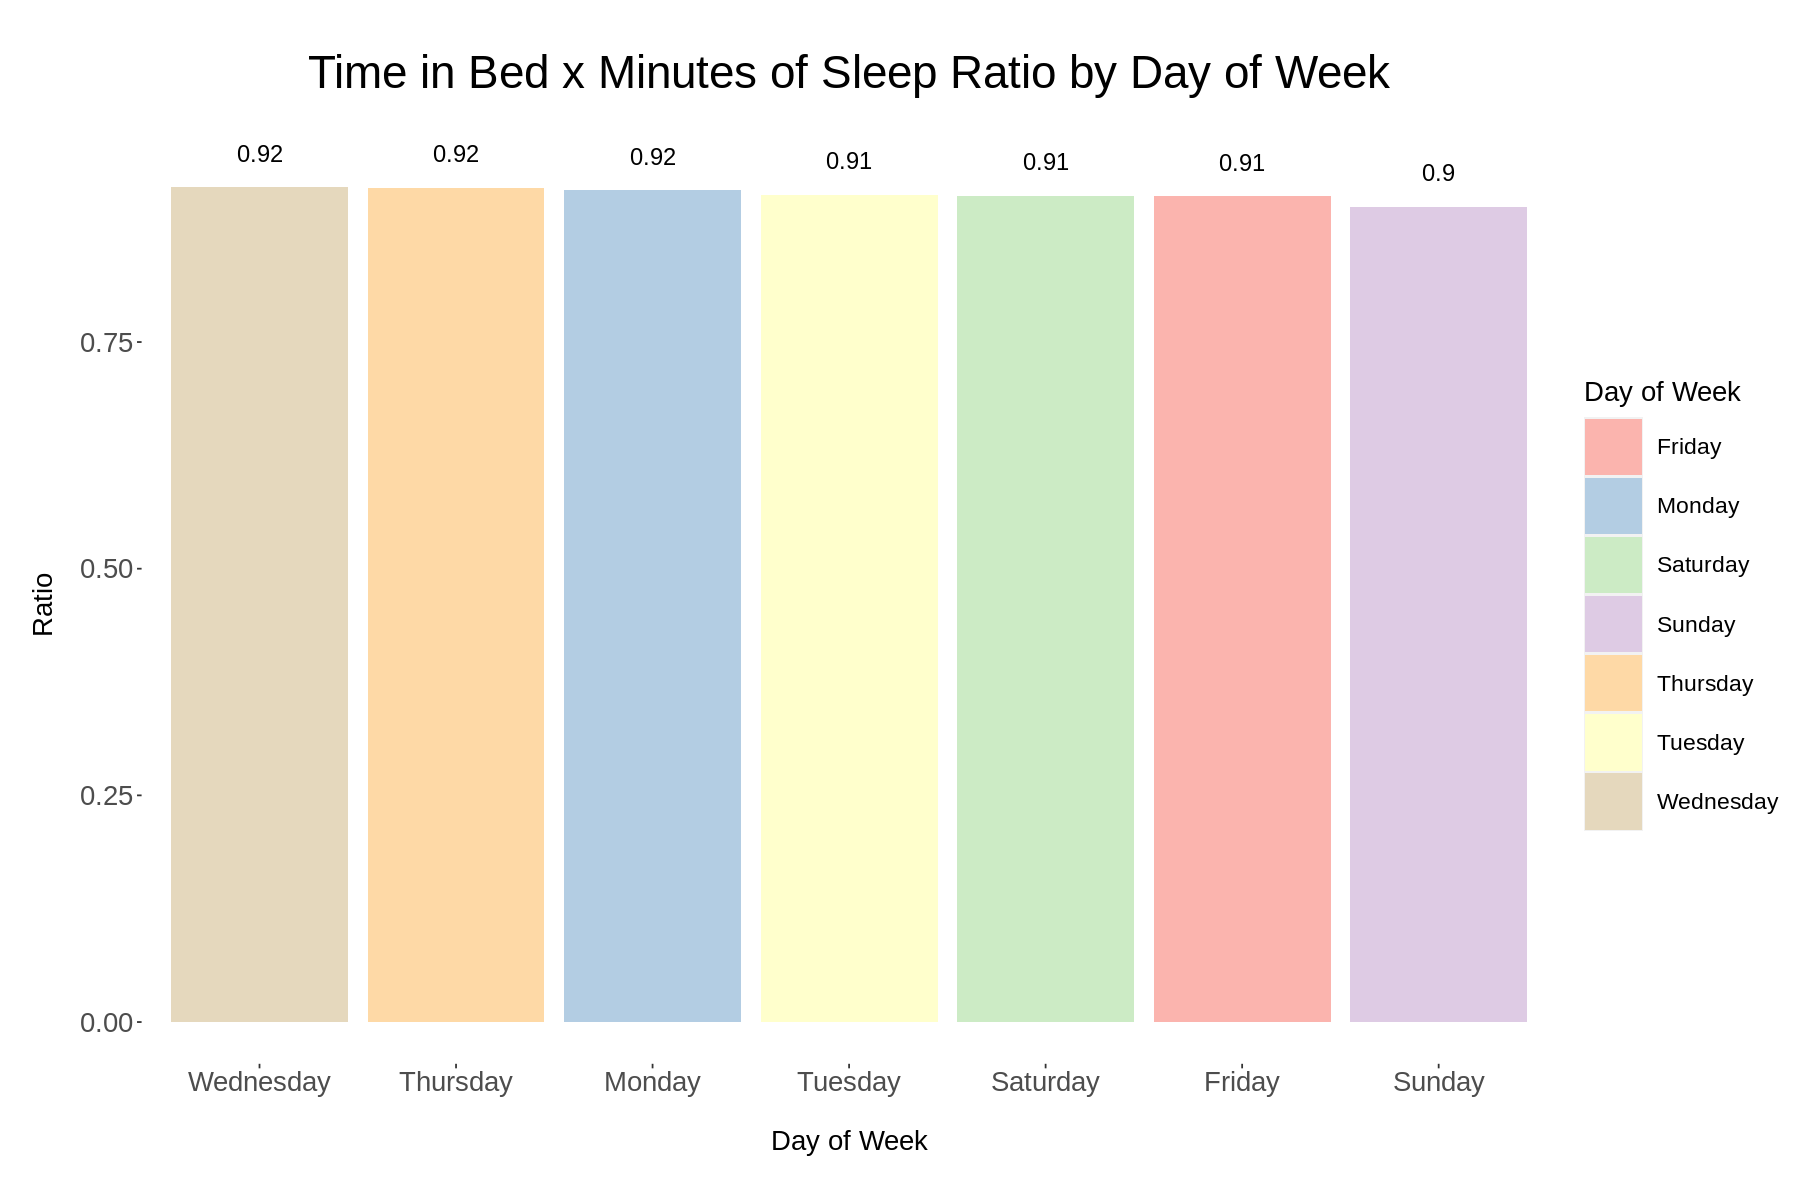

In [101]:
# Time in Bed x Minutes of Sleep
ggplot(sleep_week, aes(x = reorder(DayOfWeek, -AvgRatio), y = AvgRatio, fill = DayOfWeek)) +
  scale_fill_brewer(palette = "Pastel1") +
  geom_bar(stat = "identity") +
  geom_text(aes(label = round(AvgRatio, 2)), vjust = -1.5, size = 5) +
  labs(title = "Time in Bed x Minutes of Sleep Ratio by Day of Week",
       x = "Day of Week",
       y = "Ratio") +
  guides(fill = guide_legend(title = "Day of Week")) +
  theme(legend.key.size = unit(1.25, 'cm'),
        legend.text = element_text(size = rel(1.25)),
        legend.title = element_text(size = rel(1.5)),
        plot.title = element_text(size = rel(2.5), hjust = 0.5, margin = margin(1, 0, 1, 0, 'cm')),
        axis.text = element_text(size = rel(1.5)),
        axis.title.x = element_text(size = rel(1.5), margin = margin(0.75, 0, 0.75, 0, 'cm')),
        axis.title.y = element_text(size = rel(1.5), margin = margin(0, 0.5, 0, 0.5, 'cm')),
        panel.background  = element_blank())

The graph above reveals that on Sundays, people spend more time in bed without sleeping. This aligns with the observation that the number of calories burned and steps taken is lower on Sundays. Together, these findings suggest that Sundays are a day of the week when users generally tend to be more sedentary.

#### Complete Analysis

In [109]:
df <- merge(df_activity, df_sleep_day[, c("Id", "ActivityDate", "TotalTimeInBed", "TotalMinutesAsleep")], by.x=c("Id", "ActivityDate"), by.y=c("Id", "ActivityDate"), all.x=TRUE)
head(df)

Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,DayOfWeek,TotalTimeInBed,TotalMinutesAsleep
<int64>,<date>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<chr>,<int>,<int>
1503960366,2016-04-12,13162,8.50,8.50,0,1.88,0.55,6.06,0,25,13,328,728,1985,Tuesday,346,327
1503960366,2016-04-13,10735,6.97,6.97,0,1.57,0.69,4.71,0,21,19,217,776,1797,Wednesday,407,384
1503960366,2016-04-14,10460,6.74,6.74,0,2.44,0.40,3.91,0,30,11,181,1218,1776,Thursday,NA,NA
1503960366,2016-04-15,9762,6.28,6.28,0,2.14,1.26,2.83,0,29,34,209,726,1745,Friday,442,412
1503960366,2016-04-16,12669,8.16,8.16,0,2.71,0.41,5.04,0,36,10,221,773,1863,Saturday,367,340
1503960366,2016-04-17,9705,6.48,6.48,0,3.19,0.78,2.51,0,38,20,164,539,1728,Sunday,712,700


In [111]:
# Inputting missing values with the median
df <- df %>%
  mutate_all(
    ~ ifelse(is.na(.), median(., na.rm = TRUE), .)
)

In [113]:
features = df %>% select(c('TotalSteps', 'TotalDistance', 'VeryActiveDistance', 'ModeratelyActiveDistance',
'LightActiveDistance', 'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes', 'LightlyActiveMinutes',
'SedentaryMinutes', 'Calories', 'TotalTimeInBed', 'TotalMinutesAsleep'))
head(features)

TotalSteps,TotalDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalTimeInBed,TotalMinutesAsleep
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
13162,8.50,1.88,0.55,6.06,0,25,13,328,728,1985,346,327.0
10735,6.97,1.57,0.69,4.71,0,21,19,217,776,1797,407,384.0
10460,6.74,2.44,0.40,3.91,0,30,11,181,1218,1776,463,432.5
9762,6.28,2.14,1.26,2.83,0,29,34,209,726,1745,442,412.0
12669,8.16,2.71,0.41,5.04,0,36,10,221,773,1863,367,340.0
9705,6.48,3.19,0.78,2.51,0,38,20,164,539,1728,712,700.0


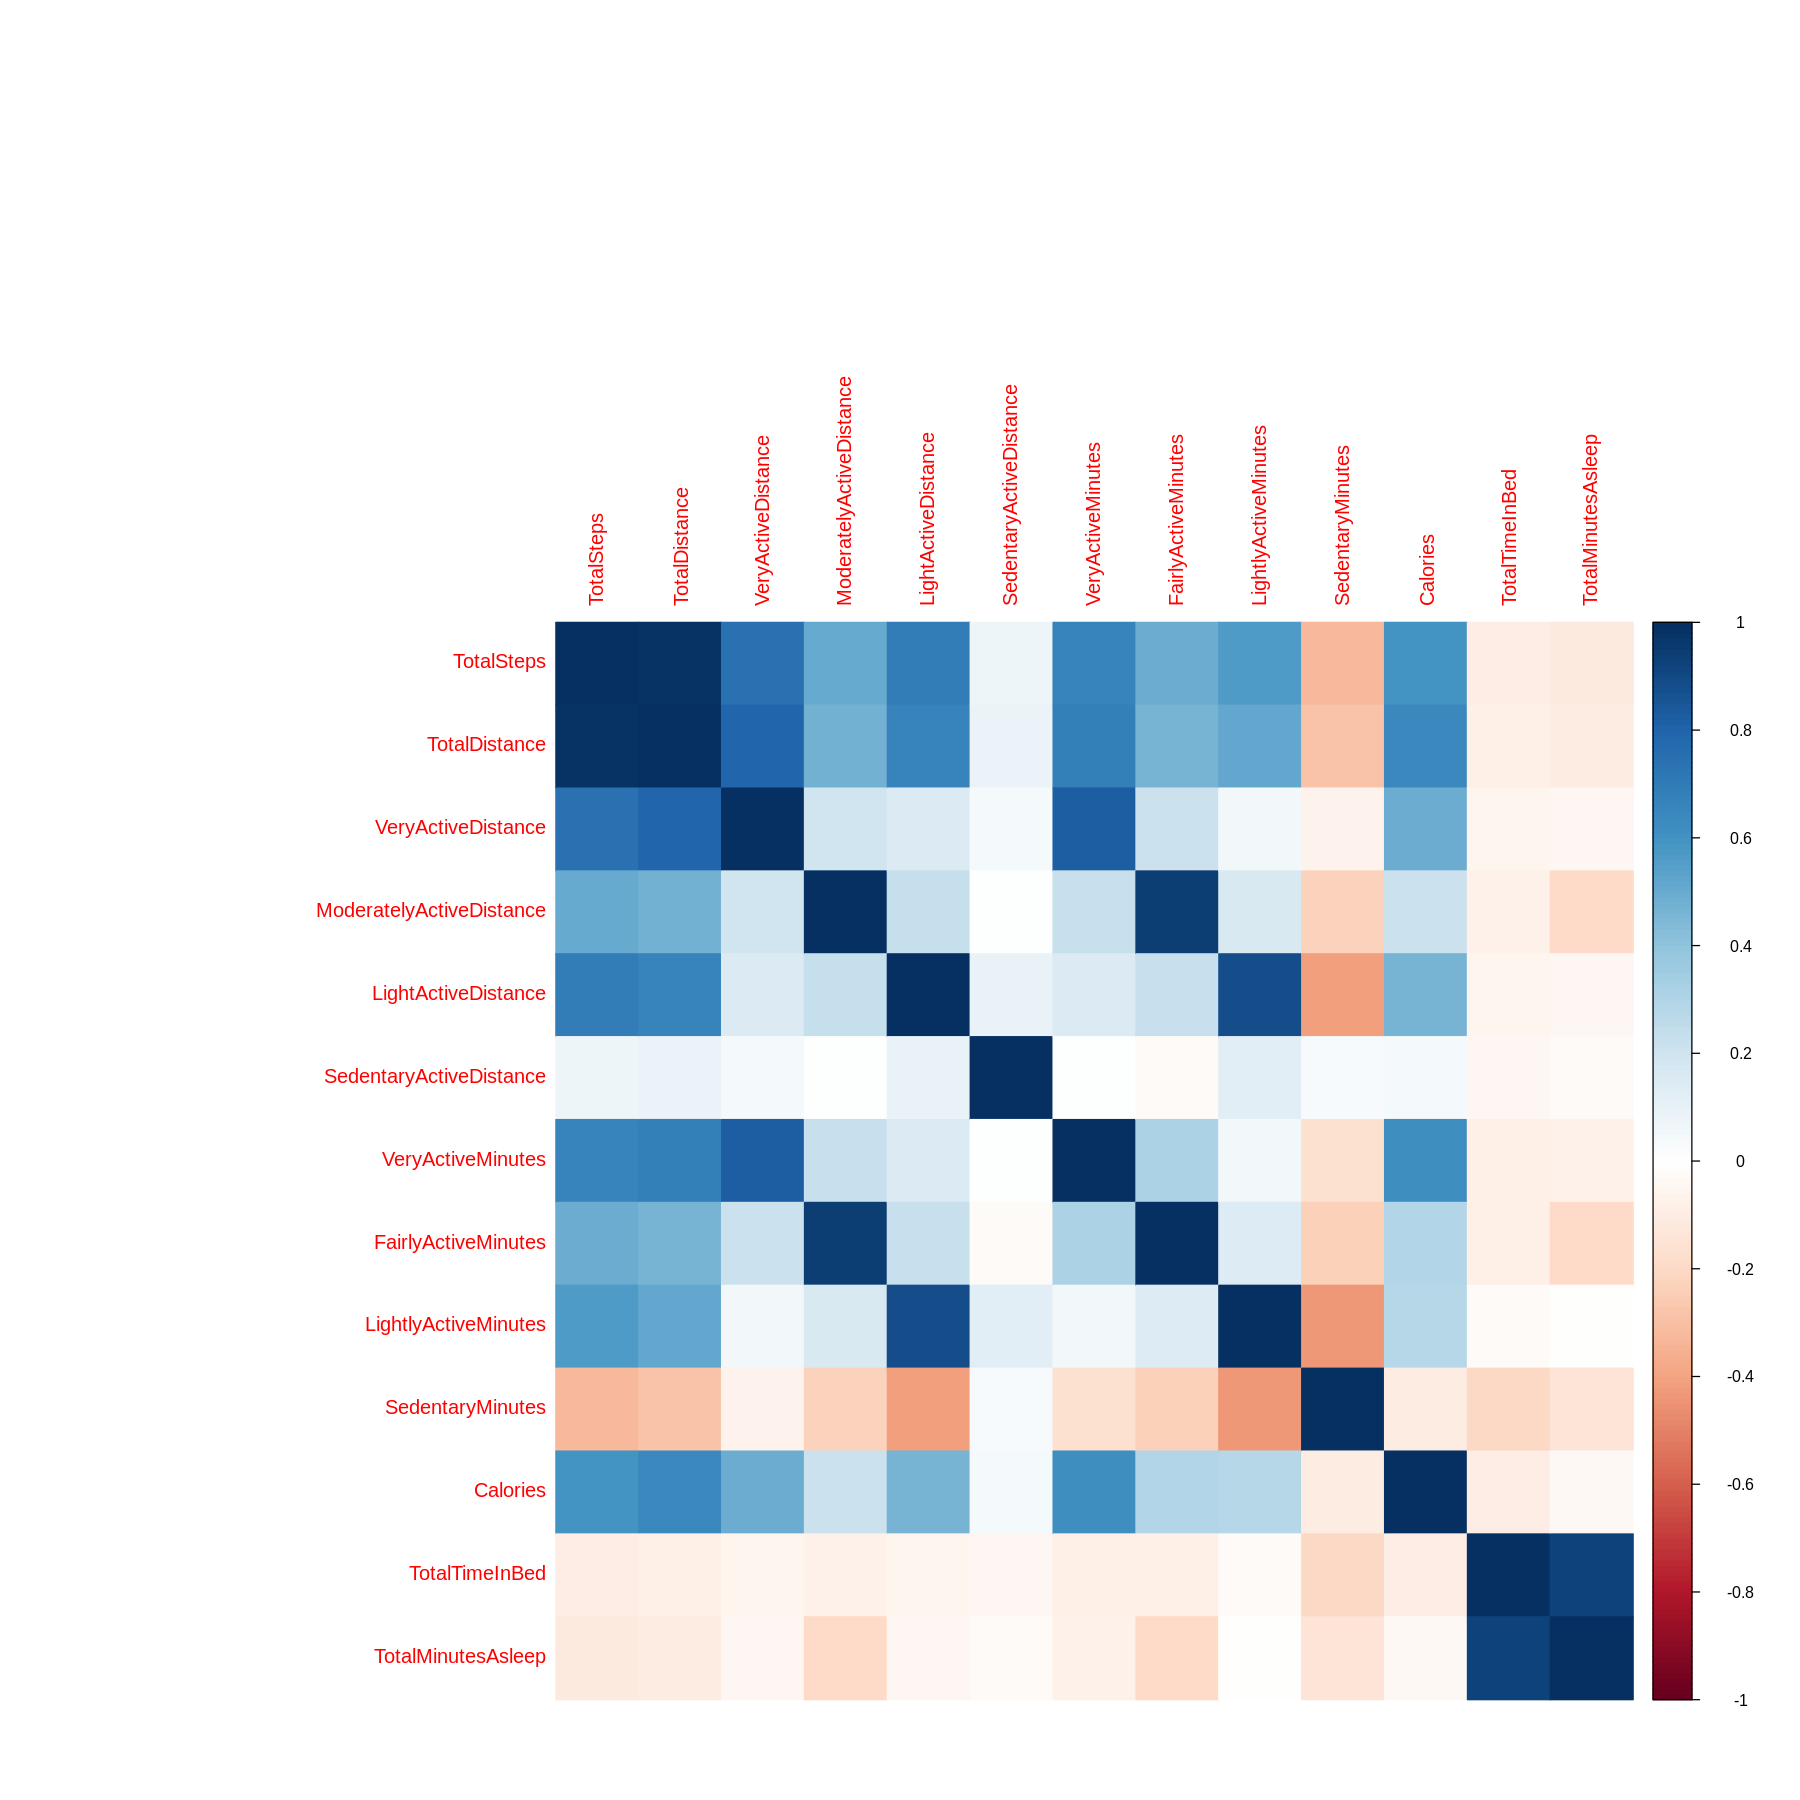

In [114]:
options(repr.plot.width = 15, repr.plot.height = 15)
corrplot(cor(features), method = "color")

The strong correlation between Active Distances, Active Minutes and Total Steps might indicate a preference for physical activities that involve moving from one place to another (such as walking or running).

In [115]:
cor(features)

,TotalSteps,TotalDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalTimeInBed,TotalMinutesAsleep
TotalSteps,1.00000000,0.98536884,0.74011458,0.507105449,0.69220820,0.070504742,0.667078697,0.49869337,0.569600207,-0.32748355,0.59156809,-0.09366671,-0.115065275
TotalDistance,0.98536884,1.00000000,0.79458162,0.470758273,0.66200154,0.082389046,0.681297434,0.46289889,0.516300493,-0.28809436,0.64496187,-0.08559606,-0.100112055
VeryActiveDistance,0.74011458,0.79458162,1.00000000,0.192985874,0.15766926,0.046116748,0.826681461,0.21173011,0.059845380,-0.06175419,0.49195856,-0.05407436,-0.049081004
ModeratelyActiveDistance,0.50710545,0.47075827,0.19298587,1.000000000,0.23784745,0.005793403,0.225464009,0.94693404,0.162091885,-0.22143606,0.21678987,-0.07820699,-0.196719244
LightActiveDistance,0.69220820,0.66200154,0.15766926,0.237847447,1.00000000,0.099503204,0.154966479,0.22012907,0.885697067,-0.41355171,0.46691676,-0.05967099,-0.044141939
SedentaryActiveDistance,0.07050474,0.08238905,0.04611675,0.005793403,0.09950320,1.000000000,0.008258149,-0.02236087,0.124184729,0.03547461,0.04365187,-0.04030467,-0.023085357
VeryActiveMinutes,0.66707870,0.68129743,0.82668146,0.225464009,0.15496648,0.008258149,1.000000000,0.31242035,0.051925909,-0.16467099,0.61583827,-0.08252110,-0.072659222
FairlyActiveMinutes,0.49869337,0.46289889,0.21173011,0.946934035,0.22012907,-0.022360869,0.312420353,1.00000000,0.148819910,-0.23744642,0.29762347,-0.08973633,-0.199975201
LightlyActiveMinutes,0.56960021,0.51630049,0.05984538,0.162091885,0.88569707,0.124184729,0.051925909,0.14881991,1.000000000,-0.43710390,0.28671753,-0.02016223,-0.001689227
SedentaryMinutes,-0.32748355,-0.28809436,-0.06175419,-0.221436057,-0.41355171,0.035474606,-0.164670992,-0.23744642,-0.437103897,1.00000000,-0.10697305,-0.20401427,-0.149431883


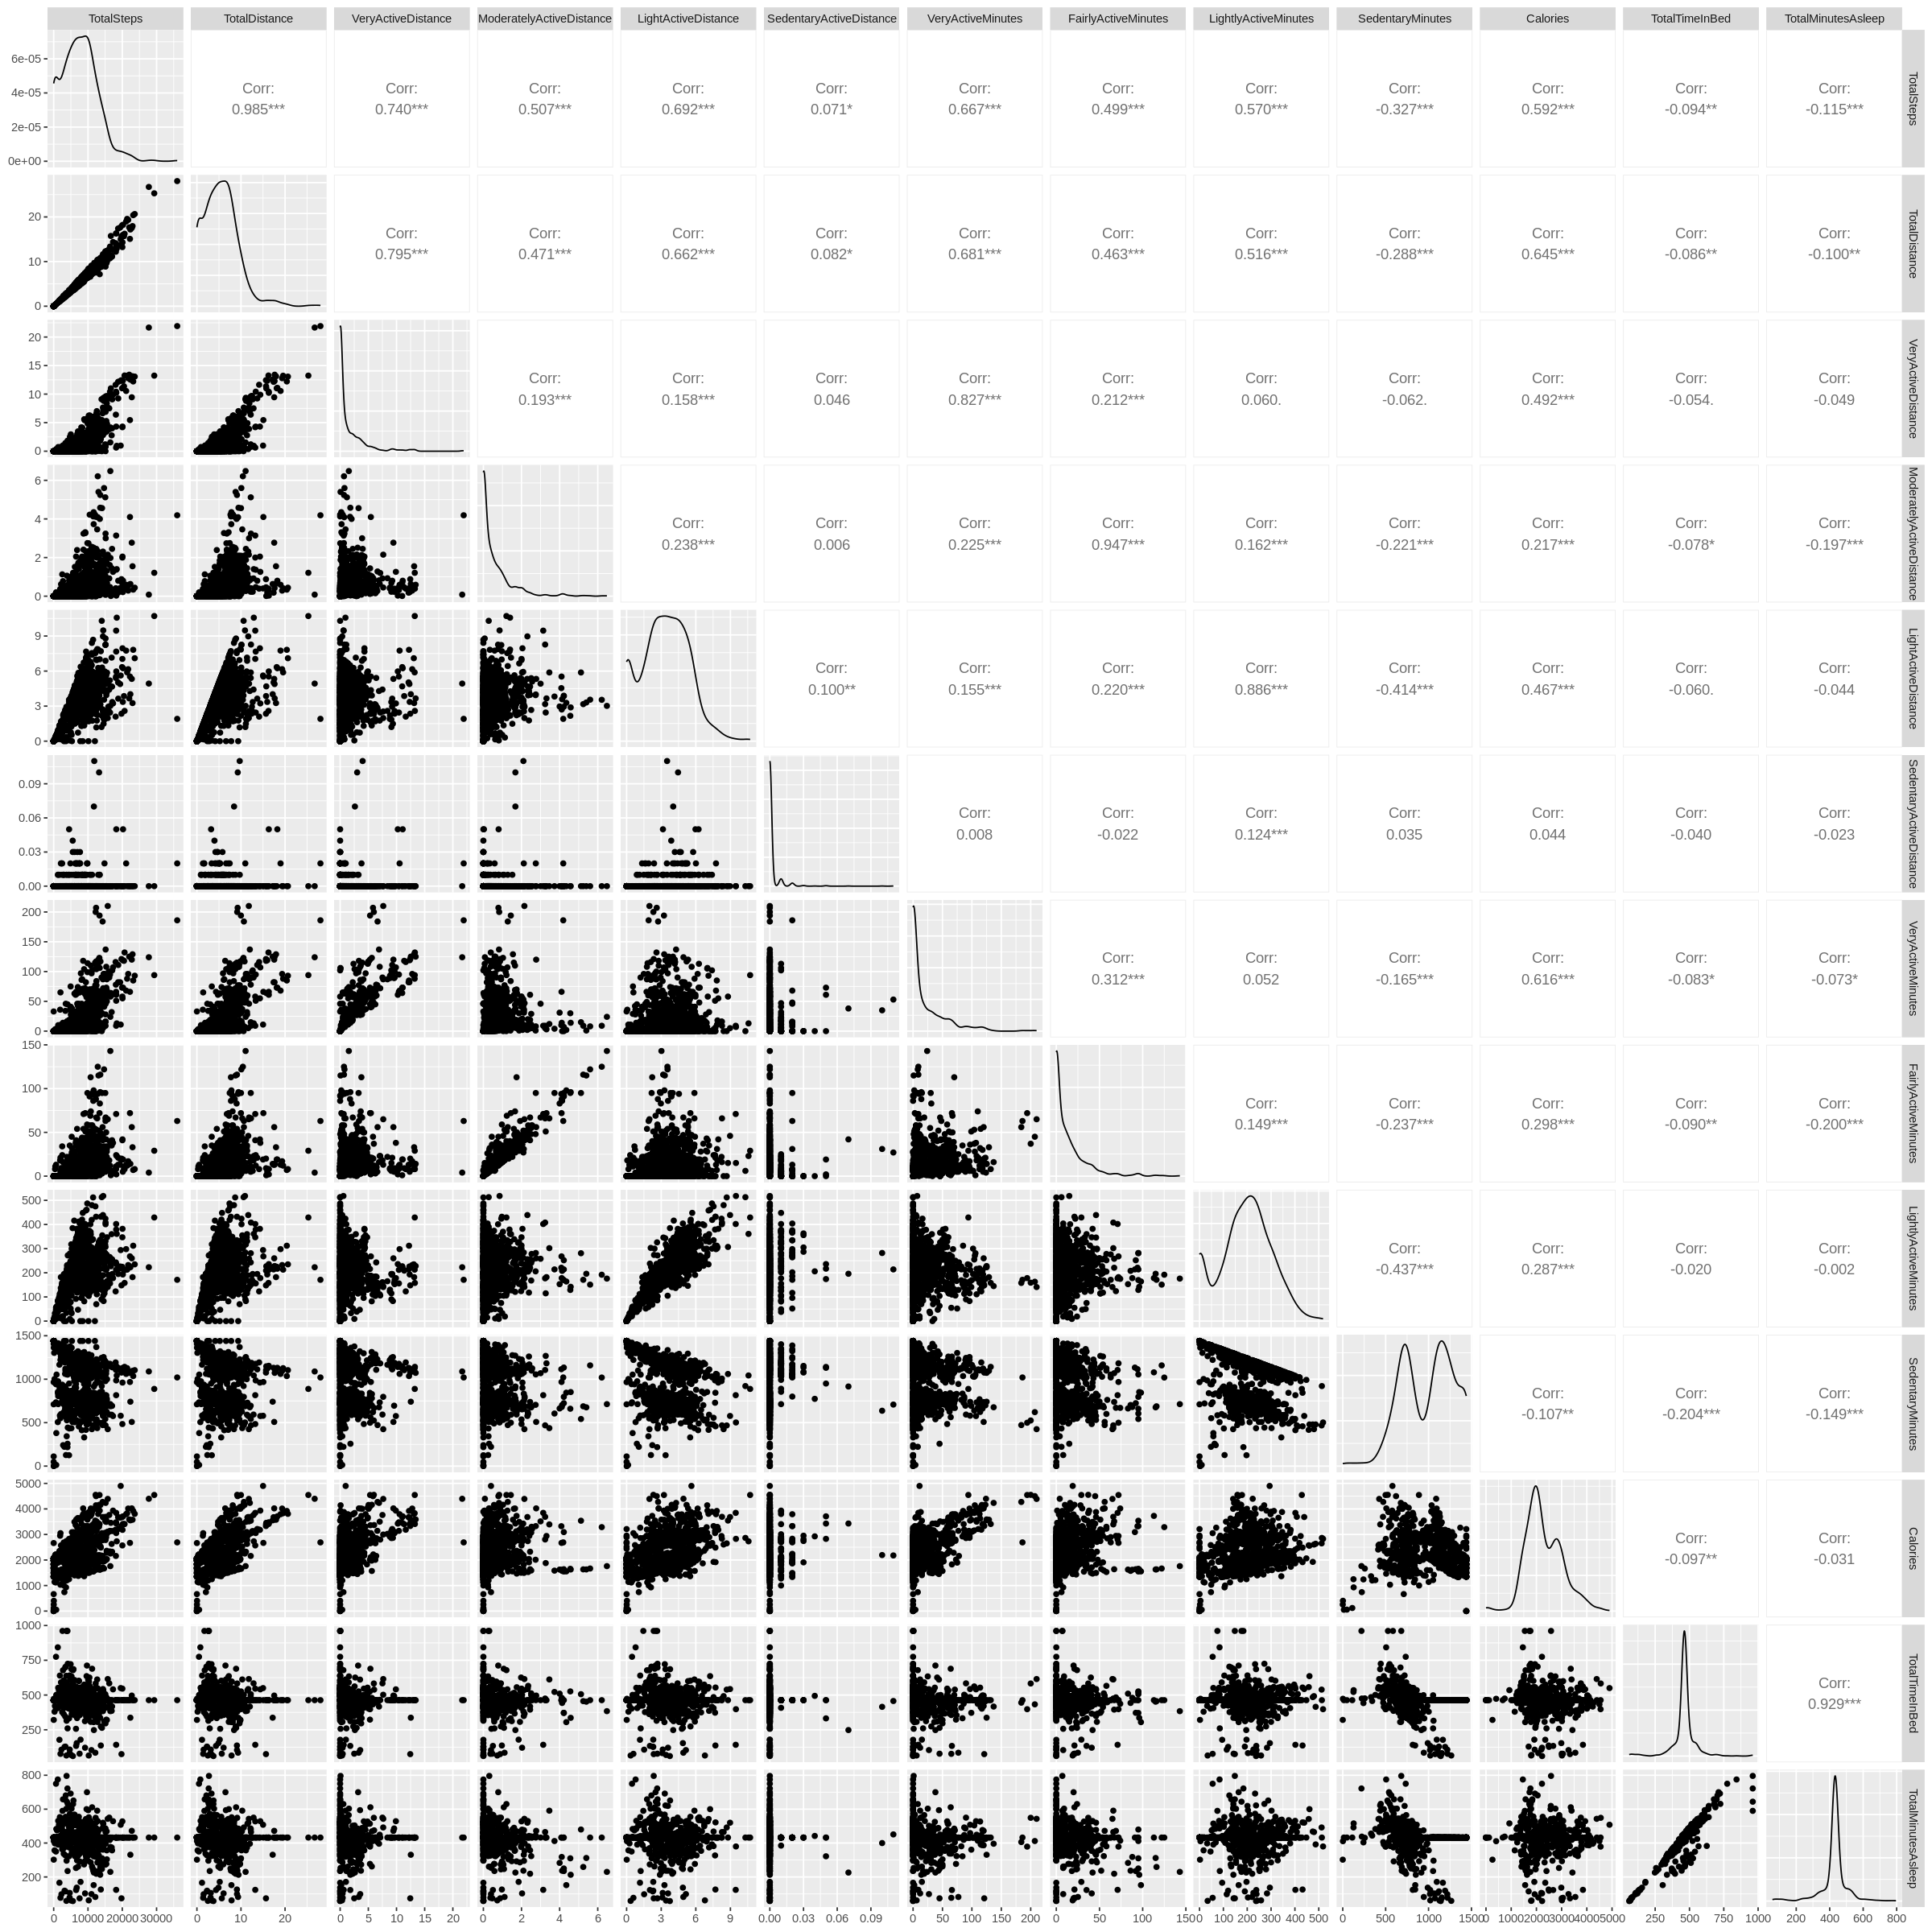

In [116]:
options(repr.plot.width = 20, repr.plot.height = 20)
ggpairs(features)

## Key Insights and Recommendations
**Active Sundays:**
   - Recognizing that people tend to be less active on Sundays, Bellabeat could design targeted marketing campaigns to encourage and motivate users to engage in wellness activities on Sundays. This could include active leisure activities, such as hiking, dancing, biking, or playing sports.

**Afternoon Activity:**
   - Given the peak of physical activity around 5-7 PM, the company should focus marketing efforts during this time to capitalize on users' interest in physical activity. Ideas for evening workouts, social activities, or challenges could be highlighted to encourage user engagement during these hours.

**Sedentary Behavior Awareness:**
   - Acknowledging that most people spend a significant portion of their day in a sedentary state, Bellabeat could develop initiatives to raise awareness about the importance of regular movement. This might involve sending reminders or notifications - through the app, wellness tracker or watch - to stand up and move around, promoting desk exercises, or even partnering with companies that offer products that encourage an active lifestyle during sedentary periods.

**Varied Activity Preferences:**
   - Since participants prefer activities involving movement from one place to another, marketing efforts can emphasize the convenience and effectiveness of such activities. Highlighting the ease of incorporating activities like walking and running into daily routines could resonate with users' preferences. However, the company should also include recommendations for short length, high intensity exercise for those who prefer this kind of activity.

**Step Count Challenges:**
   - Knowing that participants take an average of around 7,600 steps per day, which falls short of the recommended 10,000 steps, Bellabeat can create step count challenges. Marketing campaigns can promote the benefits of reaching the 10,000-step milestone and offer incentives, rewards, or recognition for users who consistently achieve or surpass this goal.

**Personalized Recommendations:**
   - Lastly, an effective marketing strategy is to use the gathered data to provide personalized recommendations and insights for individual users. Tailoring messages, e-mails and alerts based on each user's activity patterns, preferences, and progress can enhance user engagement and satisfaction.

